In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from datetime import datetime
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# Create directories for outputs if they don't exist
os.makedirs("models", exist_ok=True)
os.makedirs("merged_visualizations", exist_ok=True)

# Load the merged parking and weather data
print("Loading data...")
data_file = r"C:\Users\mohdk\OneDrive\Documents\MSDS\Winter'25\CPSC5071 Database management\project work\data\merged_parking_weather_data.csv"
df = pd.read_csv(data_file, parse_dates=["Date Time"])

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

Loading data...
Dataset shape: (838840, 29)

First few rows:
            Date Time  Elmntkey        Study_Area Sub_Area Side  \
0 2017-09-27 20:00:00   77982.0  South Lake Union    North    E   
1 2017-09-27 20:00:00   77982.0  South Lake Union    North    E   
2 2017-09-27 20:00:00   77982.0  South Lake Union    North    E   
3 2017-09-27 20:00:00   77982.0  South Lake Union    North    E   
4 2017-09-27 20:00:00   77982.0  South Lake Union    North    E   

                                      Unitdesc Peak Hour_SDOT  Parking_Spaces  \
0  DEXTER AVE N BETWEEN VALLEY ST AND ALOHA ST            NaN             2.0   
1  DEXTER AVE N BETWEEN VALLEY ST AND ALOHA ST            NaN             2.0   
2  DEXTER AVE N BETWEEN VALLEY ST AND ALOHA ST            NaN             2.0   
3  DEXTER AVE N BETWEEN VALLEY ST AND ALOHA ST            NaN             2.0   
4  DEXTER AVE N BETWEEN VALLEY ST AND ALOHA ST            NaN             2.0   

   Total_Vehicle_Count  Dp_Count  ...  Study Year

In [5]:
# Calculate available parking spots (our target variable)
df['Available_Spots'] = df['Parking_Spaces'] - df['Total_Vehicle_Count']

# Handle negative available spots (which shouldn't theoretically exist)
print(f"\nNegative available spots: {(df['Available_Spots'] < 0).sum()}")
print("Setting negative available spots to 0...")
df['Available_Spots'] = df['Available_Spots'].clip(lower=0)

# Extract time-based features from the datetime
print("\nExtracting time features...")
df['Hour'] = df['Date Time'].dt.hour
df['Day_of_Week'] = df['Date Time'].dt.dayofweek  # 0=Monday, 6=Sunday
df['Month'] = df['Date Time'].dt.month
df['Is_Weekend'] = df['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)  # Weekend flag
df['Is_Peak_Hour'] = ((df['Hour'] >= 7) & (df['Hour'] <= 9)) | ((df['Hour'] >= 16) & (df['Hour'] <= 18))
df['Is_Peak_Hour'] = df['Is_Peak_Hour'].astype(int)

# Drop unnecessary columns
print("\nDropping unnecessary columns...")
columns_to_drop = [
    'Elmntkey', 'Peak Hour_SDOT', 'Field Notes', 'TG_Car2Go', 'BMW_DN', 'Lime', 
    'Idling', 'CSM', 'Time Stamp'
]
df = df.drop(columns=columns_to_drop, errors='ignore')

# Encode categorical variables
print("\nEncoding categorical variables...")
categorical_cols = ['Study_Area', 'Sub_Area', 'Side', 'Unitdesc', 'Construction', 
                   'Event Closure', 'Subarea Label', 'Peak Hour? (Yes or No)', 'region']

# Apply label encoding to categorical columns
label_encoders = {}
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = df[col].astype(str)  # Convert to string to handle any non-string values
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Handle missing values
print("\nHandling missing values...")
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Display the processed dataframe info
print("\nProcessed dataframe info:")
print(df.info())

# Display summary statistics
print("\nSummary statistics for key columns:")
print(df[['Parking_Spaces', 'Total_Vehicle_Count', 'Available_Spots', 
          'temperature', 'precipitation', 'wind_speed']].describe())


Negative available spots: 125570
Setting negative available spots to 0...

Extracting time features...

Dropping unnecessary columns...

Encoding categorical variables...

Handling missing values...

Processed dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838840 entries, 0 to 838839
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Date Time               838840 non-null  datetime64[ns]
 1   Study_Area              838840 non-null  int64         
 2   Sub_Area                838840 non-null  int64         
 3   Side                    838840 non-null  int64         
 4   Unitdesc                838840 non-null  int64         
 5   Parking_Spaces          838840 non-null  float64       
 6   Total_Vehicle_Count     838840 non-null  float64       
 7   Dp_Count                838840 non-null  float64       
 8   Rpz_Count               838840 non-null  float6

In [6]:
# Select features for the model
print("Preparing features and target variable...")

# Define features to use in the model
features = [
    'Hour', 'Day_of_Week', 'Month', 'Is_Weekend', 'Is_Peak_Hour',
    'Study_Area', 'Sub_Area', 'Side', 'Construction', 'Event Closure',
    'Study Year', 'Parking_Spaces', 'temperature', 'precipitation', 'wind_speed', 'elevation'
]

# Ensure all selected features exist in the dataframe
features = [f for f in features if f in df.columns]
print(f"Selected features: {features}")

# Define target variable
target = 'Available_Spots'

# Prepare the feature matrix and target vector
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Scale numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Save the scaler for future use
joblib.dump(scaler, 'models/scaler.pkl')

Preparing features and target variable...
Selected features: ['Hour', 'Day_of_Week', 'Month', 'Is_Weekend', 'Is_Peak_Hour', 'Study_Area', 'Sub_Area', 'Side', 'Construction', 'Event Closure', 'Study Year', 'Parking_Spaces', 'temperature', 'precipitation', 'wind_speed', 'elevation']
Training set shape: (671072, 16)
Testing set shape: (167768, 16)


['models/scaler.pkl']

In [7]:
# Function to calculate relative error
def relative_error(y_true, y_pred):
    """Calculate mean relative error: |actual - predicted| / actual"""
    # Avoid division by zero
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

# Function to evaluate model performance
def evaluate_model(model, X, y, model_name="Model"):
    """Evaluate model performance and return metrics"""
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    rel_error = relative_error(y, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Relative Error: {rel_error:.4f}")
    
    return {
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'relative_error': rel_error
    }

# Initialize models to try
models = {
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}

# Perform 10-fold cross-validation with 10 iterations for each model
print("Performing 10-fold cross-validation with 10 iterations...")

# Create a DataFrame to store all results
cv_results = pd.DataFrame()

# Number of iterations
n_iterations = 10

# For each model
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    
    # For each iteration
    for iteration in range(n_iterations):
        print(f"Iteration {iteration+1}/{n_iterations}")
        
        # Create a KFold object
        kf = KFold(n_splits=10, shuffle=True, random_state=iteration)
        
        # For each fold
        fold = 0
        for train_index, val_index in kf.split(X_train):
            fold += 1
            # Split the data
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
            
            # Train the model
            model.fit(X_train_fold, y_train_fold)
            
            # Evaluate on training set
            y_train_pred = model.predict(X_train_fold)
            train_mse = mean_squared_error(y_train_fold, y_train_pred)
            train_rmse = np.sqrt(train_mse)
            train_r2 = r2_score(y_train_fold, y_train_pred)
            train_rel_error = relative_error(y_train_fold, y_train_pred)
            
            # Evaluate on validation set
            y_val_pred = model.predict(X_val_fold)
            val_mse = mean_squared_error(y_val_fold, y_val_pred)
            val_rmse = np.sqrt(val_mse)
            val_r2 = r2_score(y_val_fold, y_val_pred)
            val_rel_error = relative_error(y_val_fold, y_val_pred)
            
            # Store results
            result = {
                'Model': model_name,
                'Iteration': iteration + 1,
                'Fold': fold,
                'Train_MSE': train_mse,
                'Train_RMSE': train_rmse,
                'Train_R2': train_r2,
                'Train_RelError': train_rel_error,
                'Val_MSE': val_mse,
                'Val_RMSE': val_rmse,
                'Val_R2': val_r2,
                'Val_RelError': val_rel_error
            }
            
            # Append to results DataFrame
            cv_results = pd.concat([cv_results, pd.DataFrame([result])], ignore_index=True)
    
    # Print average results for this model
    print(f"\nAverage CV Results for {model_name}:")
    model_results = cv_results[cv_results['Model'] == model_name]
    print(f"Training MSE: {model_results['Train_MSE'].mean():.4f} ± {model_results['Train_MSE'].std():.4f}")
    print(f"Training RMSE: {model_results['Train_RMSE'].mean():.4f} ± {model_results['Train_RMSE'].std():.4f}")
    print(f"Training R²: {model_results['Train_R2'].mean():.4f} ± {model_results['Train_R2'].std():.4f}")
    print(f"Training Relative Error: {model_results['Train_RelError'].mean():.4f} ± {model_results['Train_RelError'].std():.4f}")
    print(f"Validation MSE: {model_results['Val_MSE'].mean():.4f} ± {model_results['Val_MSE'].std():.4f}")
    print(f"Validation RMSE: {model_results['Val_RMSE'].mean():.4f} ± {model_results['Val_RMSE'].std():.4f}")
    print(f"Validation R²: {model_results['Val_R2'].mean():.4f} ± {model_results['Val_R2'].std():.4f}")
    print(f"Validation Relative Error: {model_results['Val_RelError'].mean():.4f} ± {model_results['Val_RelError'].std():.4f}")

# Save cross-validation results to CSV
cv_results.to_csv('models/cross_validation_results.csv', index=False)
print("\nCross-validation results saved to 'models/cross_validation_results.csv'")

Performing 10-fold cross-validation with 10 iterations...

Evaluating XGBoost...
Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10

Average CV Results for XGBoost:
Training MSE: 3.2770 ± 0.0213
Training RMSE: 1.8102 ± 0.0059
Training R²: 0.7463 ± 0.0017
Training Relative Error: 0.5145 ± 0.0014
Validation MSE: 3.3713 ± 0.0405
Validation RMSE: 1.8361 ± 0.0110
Validation R²: 0.7389 ± 0.0056
Validation Relative Error: 0.5187 ± 0.0032

Evaluating RandomForest...
Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10

Average CV Results for RandomForest:
Training MSE: 0.9375 ± 0.0023
Training RMSE: 0.9683 ± 0.0012
Training R²: 0.9274 ± 0.0002
Training Relative Error: 0.2485 ± 0.0003
Validation MSE: 2.1623 ± 0.0327
Validation RMSE: 1.4704 ± 0.0111
Validation R²: 0.8325 ± 0.0038
Validation Relative E

In [8]:
# Identify the best model based on validation R²
best_model_name = cv_results.groupby('Model')['Val_R2'].mean().idxmax()
print(f"\nBest model based on validation R²: {best_model_name}")

# Train the best model on the entire training set
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

# Evaluate on training set
print("\nFinal model performance on training set:")
train_metrics = evaluate_model(best_model, X_train, y_train, "Training")

# Evaluate on test set
print("\nFinal model performance on test set:")
test_metrics = evaluate_model(best_model, X_test, y_test, "Test")

# Save the final model
joblib.dump(best_model, f'models/{best_model_name}_final_model.pkl')
print(f"\nFinal model saved to 'models/{best_model_name}_final_model.pkl'")

# Create a DataFrame with final results
final_results = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'R²', 'Relative Error'],
    'Training': [train_metrics['mse'], train_metrics['rmse'], train_metrics['r2'], train_metrics['relative_error']],
    'Testing': [test_metrics['mse'], test_metrics['rmse'], test_metrics['r2'], test_metrics['relative_error']]
})

# Save final results
final_results.to_csv('models/final_model_performance.csv', index=False)
print("\nFinal model performance metrics saved to 'models/final_model_performance.csv'")


Best model based on validation R²: RandomForest

Final model performance on training set:
Training Performance:
MSE: 0.9773
RMSE: 0.9886
R²: 0.9243
Relative Error: 0.2522

Final model performance on test set:
Test Performance:
MSE: 2.1537
RMSE: 1.4675
R²: 0.8343
Relative Error: 0.3970

Final model saved to 'models/RandomForest_final_model.pkl'

Final model performance metrics saved to 'models/final_model_performance.csv'


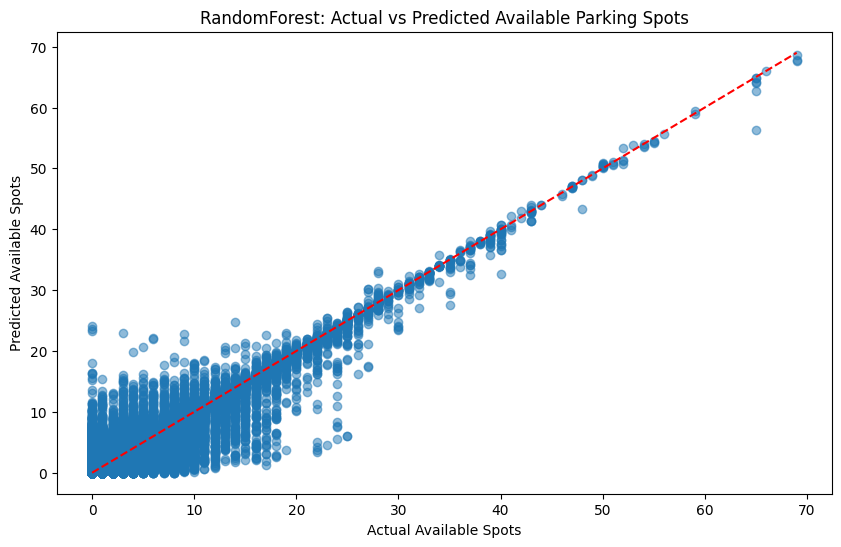

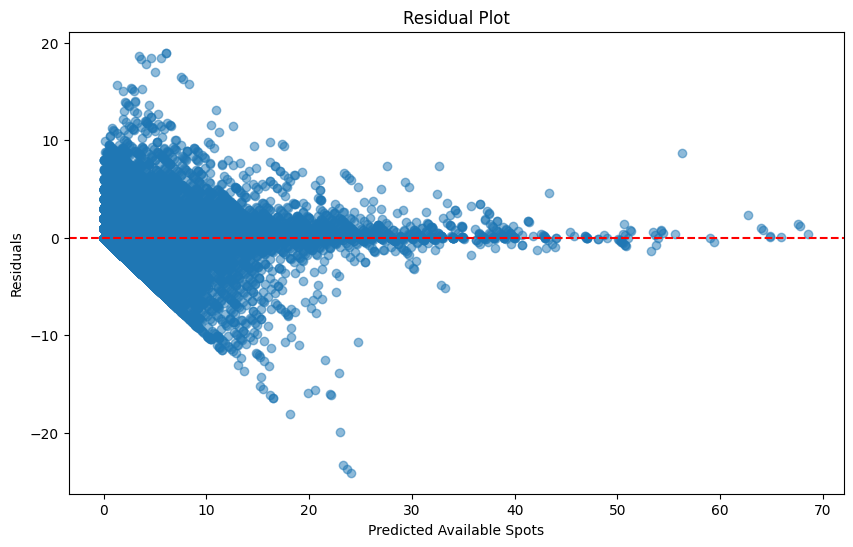

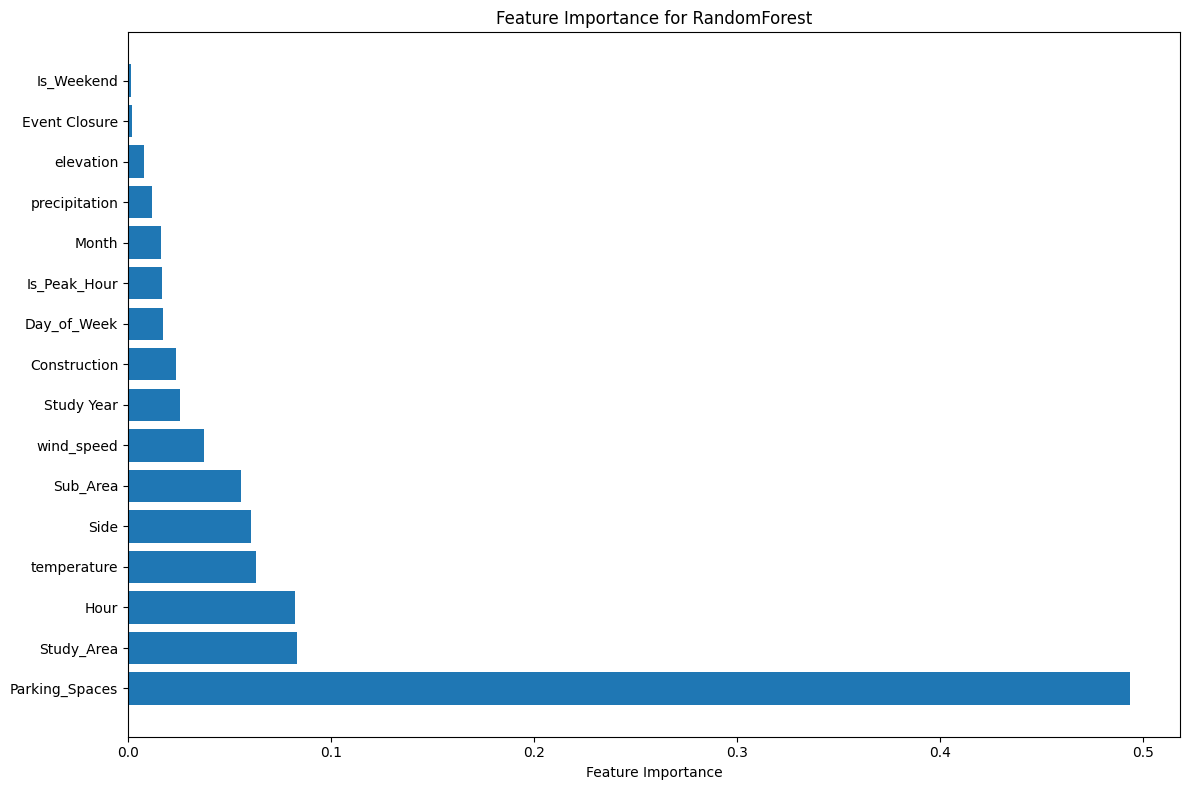

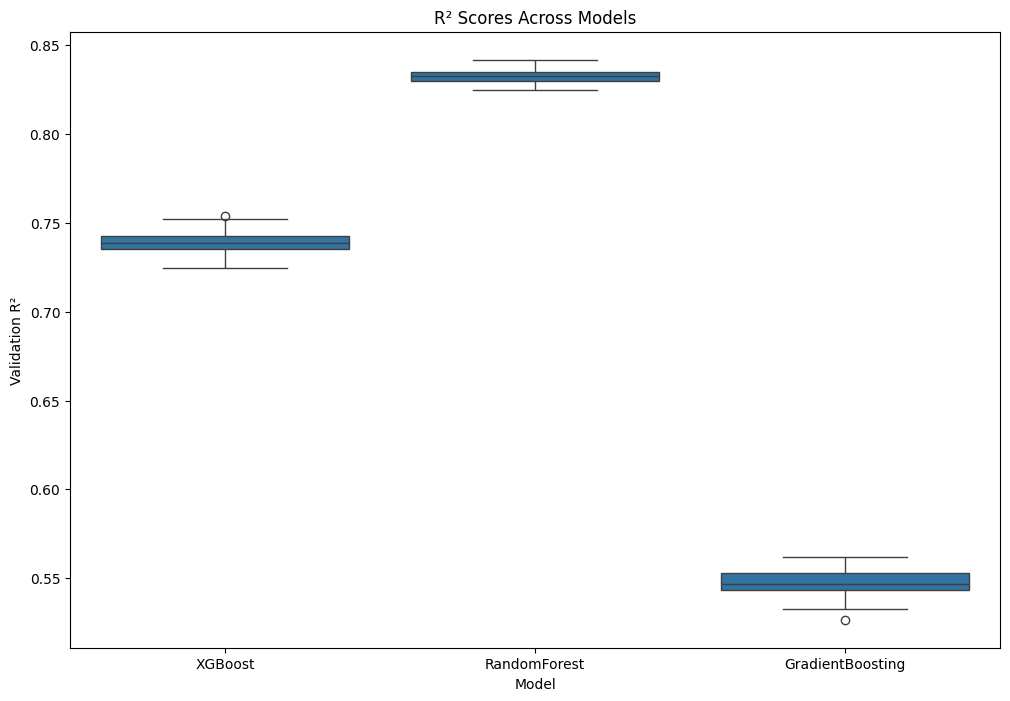

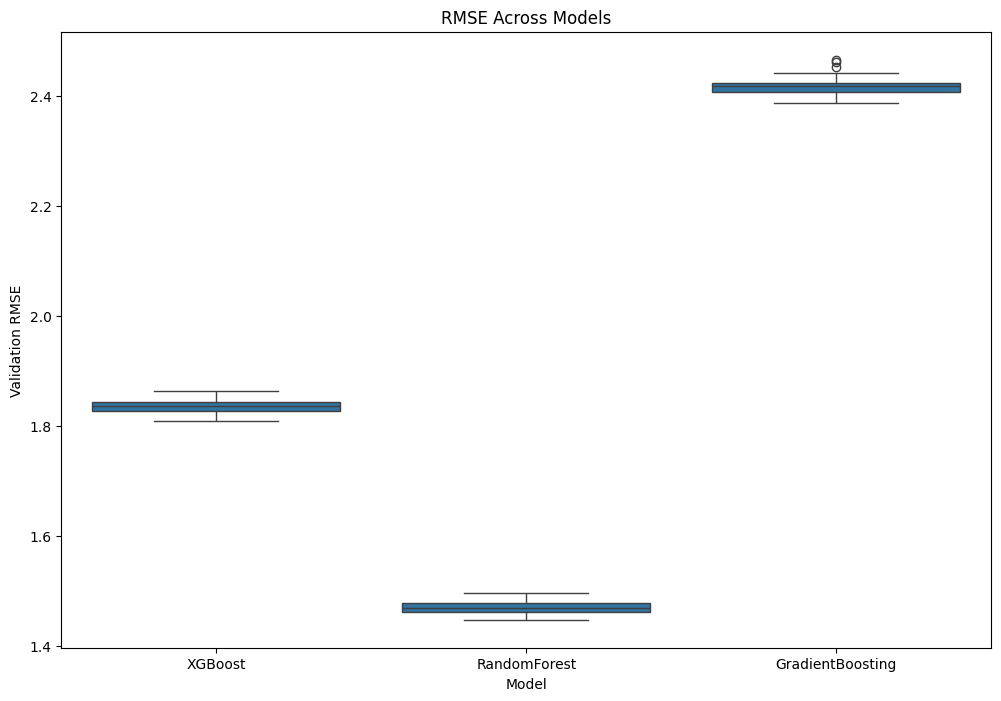

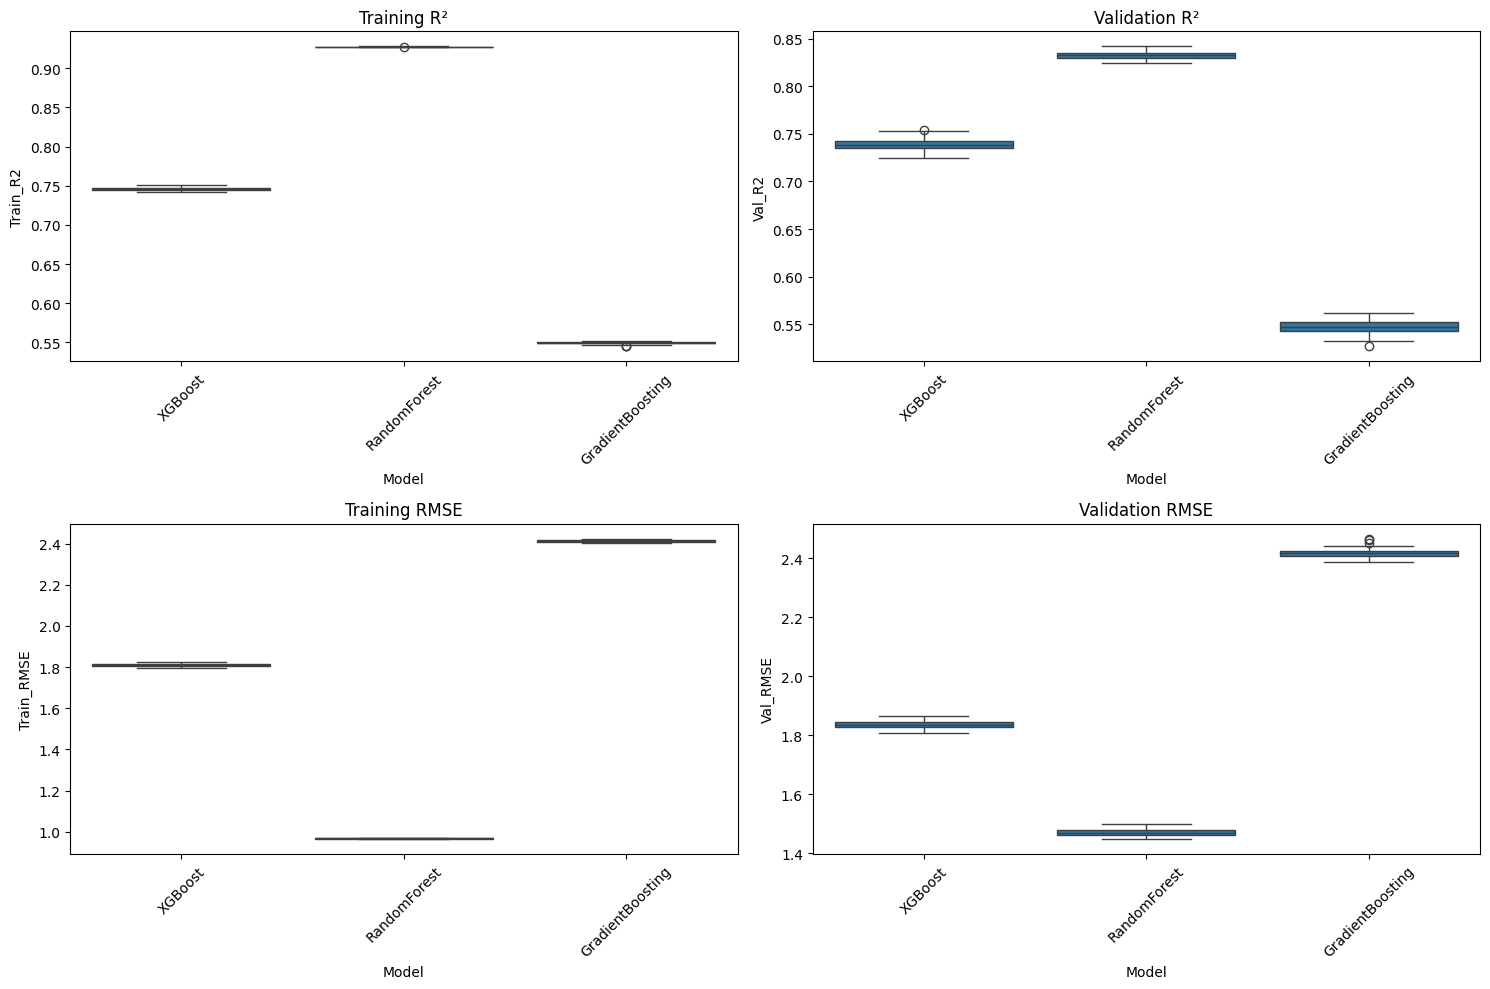

In [9]:
# Visualize actual vs predicted values on test set
y_pred = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Available Spots')
plt.ylabel('Predicted Available Spots')
plt.title(f'{best_model_name}: Actual vs Predicted Available Parking Spots')
plt.savefig('merged_visualizations/actual_vs_predicted.png')
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Available Spots')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.savefig('merged_visualizations/residuals.png')
plt.show()

# Plot feature importance for the best model
if best_model_name in ['RandomForest', 'GradientBoosting', 'XGBoost']:
    plt.figure(figsize=(12, 8))
    
    if best_model_name == 'XGBoost':
        importance = best_model.feature_importances_
    else:
        importance = best_model.feature_importances_
    
    indices = np.argsort(importance)[::-1]
    features_sorted = [features[i] for i in indices]
    
    plt.barh(range(len(indices)), importance[indices])
    plt.yticks(range(len(indices)), features_sorted)
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for {best_model_name}')
    plt.tight_layout()
    plt.savefig('merged_visualizations/feature_importance.png')
    plt.show()

# Visualize cross-validation results
plt.figure(figsize=(12, 8))
sns.boxplot(x='Model', y='Val_R2', data=cv_results)
plt.title('R² Scores Across Models')
plt.ylabel('Validation R²')
plt.savefig('merged_visualizations/model_comparison_r2.png')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='Model', y='Val_RMSE', data=cv_results)
plt.title('RMSE Across Models')
plt.ylabel('Validation RMSE')
plt.savefig('merged_visualizations/model_comparison_rmse.png')
plt.show()

# Plot training vs validation metrics to check for overfitting
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='Model', y='Train_R2', data=cv_results)
plt.title('Training R²')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.boxplot(x='Model', y='Val_R2', data=cv_results)
plt.title('Validation R²')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
sns.boxplot(x='Model', y='Train_RMSE', data=cv_results)
plt.title('Training RMSE')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.boxplot(x='Model', y='Val_RMSE', data=cv_results)
plt.title('Validation RMSE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('merged_visualizations/training_vs_validation.png')
plt.show()

Temperature statistics in test data:
count    167768.000000
mean          0.001126
std           1.000652
min          -2.588101
25%          -0.749485
50%          -0.167645
75%           0.646932
max           4.324164
Name: Temperature, dtype: float64
Temperature bins: [np.float64(-2.6), np.float64(-0.9), np.float64(-0.4), np.float64(0.1), np.float64(0.9), np.float64(4.3)]
Temperature labels: ['-2.6°C to -0.9°C', '-0.9°C to -0.4°C', '-0.4°C to 0.1°C', '0.1°C to 0.9°C', '0.9°C to 4.3°C']
Samples in each temperature category:
Temp_Category
-2.6°C to -0.9°C    32081
-0.9°C to -0.4°C    34615
-0.4°C to 0.1°C     31766
0.1°C to 0.9°C      36600
0.9°C to 4.3°C      32704
Name: count, dtype: int64


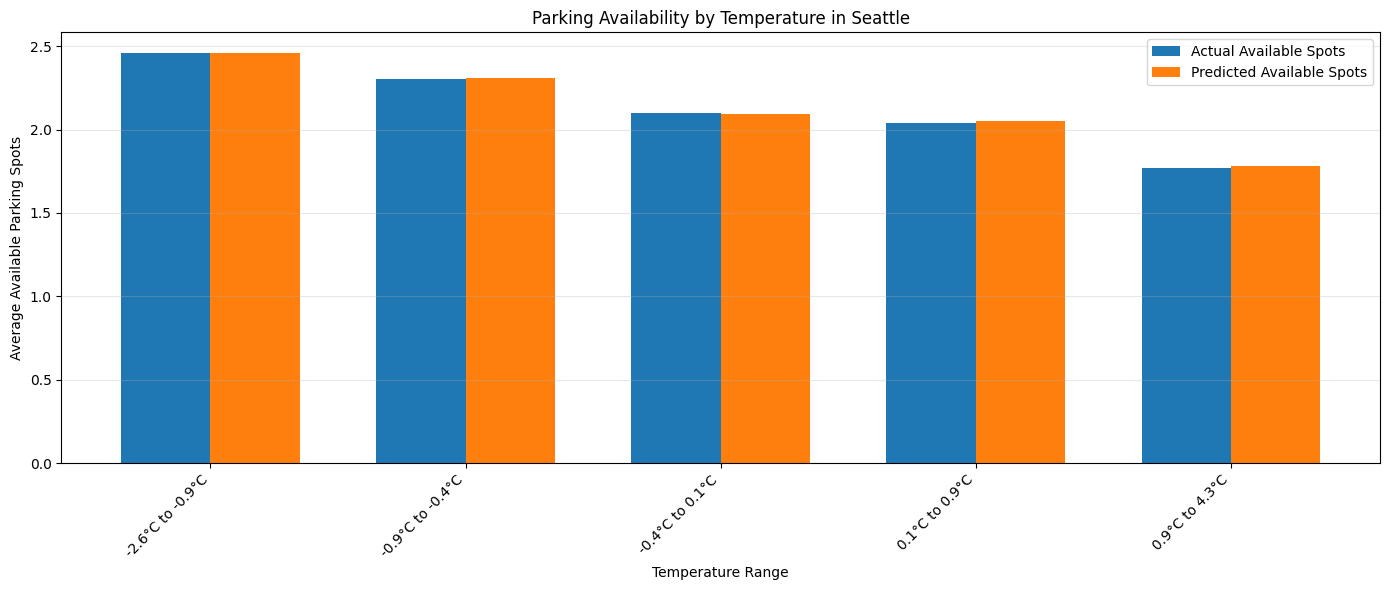

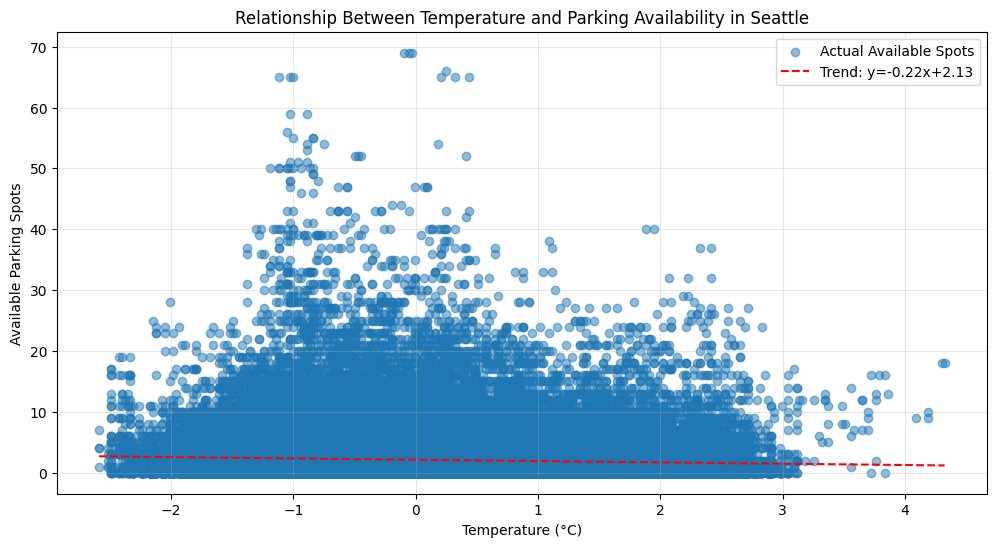

In [18]:
# 3. Analyze availability by weather conditions (if available)
if 'Temperature' in prediction_analysis.columns and prediction_analysis['Temperature'].notna().any():
    # First, let's see the actual temperature distribution in our data
    print("Temperature statistics in test data:")
    print(prediction_analysis['Temperature'].describe())
    
    # Create Seattle-specific temperature categories based on actual data distribution
    temp_min = prediction_analysis['Temperature'].min()
    temp_max = prediction_analysis['Temperature'].max()
    
    # Create more appropriate bins based on Seattle's climate and our actual data
    # Use quantiles to ensure we have data in each category
    temp_bins = [
        prediction_analysis['Temperature'].quantile(0),  # Min
        prediction_analysis['Temperature'].quantile(0.2),
        prediction_analysis['Temperature'].quantile(0.4),
        prediction_analysis['Temperature'].quantile(0.6),
        prediction_analysis['Temperature'].quantile(0.8),
        prediction_analysis['Temperature'].quantile(1.0)  # Max
    ]
    
    # Round the bin edges for better readability
    temp_bins = [round(x, 1) for x in temp_bins]
    
    # Make sure bins are unique (in case of many identical values)
    temp_bins = sorted(list(set(temp_bins)))
    
    # If we still have fewer than 3 unique bins, create artificial ones
    if len(temp_bins) < 3:
        temp_range = temp_max - temp_min
        if temp_range < 1:  # Very small range
            temp_bins = [temp_min - 0.5, temp_min, temp_max, temp_max + 0.5]
        else:
            step = temp_range / 4
            temp_bins = [temp_min, temp_min + step, temp_min + 2*step, temp_min + 3*step, temp_max]
    
    # Create labels based on the actual bin values
    temp_labels = [f"{temp_bins[i]:.1f}°C to {temp_bins[i+1]:.1f}°C" for i in range(len(temp_bins)-1)]
    
    print(f"Temperature bins: {temp_bins}")
    print(f"Temperature labels: {temp_labels}")
    
    # Apply the custom bins to create temperature categories
    prediction_analysis['Temp_Category'] = pd.cut(
        prediction_analysis['Temperature'],
        bins=temp_bins,
        labels=temp_labels,
        include_lowest=True
    )
    
    # Count samples in each category to verify distribution
    temp_counts = prediction_analysis['Temp_Category'].value_counts().sort_index()
    print("Samples in each temperature category:")
    print(temp_counts)
    
    # Only proceed if we have at least 2 categories with data
    if len(temp_counts) >= 2:
        temp_availability = prediction_analysis.groupby('Temp_Category').agg({
            'Actual_Available': 'mean',
            'Predicted_Available': 'mean',
            'Actual_Occupancy_Rate': 'mean' if 'Actual_Occupancy_Rate' in prediction_analysis.columns else 'count',
            'Predicted_Occupancy_Rate': 'mean' if 'Predicted_Occupancy_Rate' in prediction_analysis.columns else 'count'
        }).reset_index()
        
        plt.figure(figsize=(14, 6))
        x = np.arange(len(temp_availability))
        width = 0.35
        plt.bar(x - width/2, temp_availability['Actual_Available'], width, label='Actual Available Spots')
        plt.bar(x + width/2, temp_availability['Predicted_Available'], width, label='Predicted Available Spots')
        plt.xlabel('Temperature Range')
        plt.ylabel('Average Available Parking Spots')
        plt.title('Parking Availability by Temperature in Seattle')
        plt.xticks(x, temp_availability['Temp_Category'], rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.legend()
        plt.tight_layout()
        plt.savefig('merged_visualizations/availability_by_temperature.png')
        plt.show()
        
        # Also create a scatter plot to show the continuous relationship
        plt.figure(figsize=(12, 6))
        plt.scatter(prediction_analysis['Temperature'], prediction_analysis['Actual_Available'], 
                   alpha=0.5, label='Actual Available Spots')
        
        # Add a trend line
        z = np.polyfit(prediction_analysis['Temperature'], prediction_analysis['Actual_Available'], 1)
        p = np.poly1d(z)
        plt.plot(sorted(prediction_analysis['Temperature']), 
                p(sorted(prediction_analysis['Temperature'])), 
                "r--", label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
        
        plt.xlabel('Temperature (°C)')
        plt.ylabel('Available Parking Spots')
        plt.title('Relationship Between Temperature and Parking Availability in Seattle')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.savefig('merged_visualizations/temperature_vs_availability_scatter.png')
        plt.show()
    else:
        print("Warning: Not enough temperature variation in the test data to create a meaningful categorical plot")

posx and posy should be finite values
posx and posy should be finite values


Analyzing weather impact on parking availability in Seattle...

Precipitation statistics in Seattle (test data):
count    167768.000000
mean          0.001995
std           0.998460
min          -0.378795
25%          -0.378795
50%          -0.378795
75%          -0.121388
max          11.461932
Name: Precipitation, dtype: float64

Samples in each precipitation category:
Rain_Category
No Rain              0
Drizzle          19273
Light Rain       10299
Moderate Rain     2987
Heavy Rain        1821
Name: count, dtype: int64


posx and posy should be finite values
posx and posy should be finite values


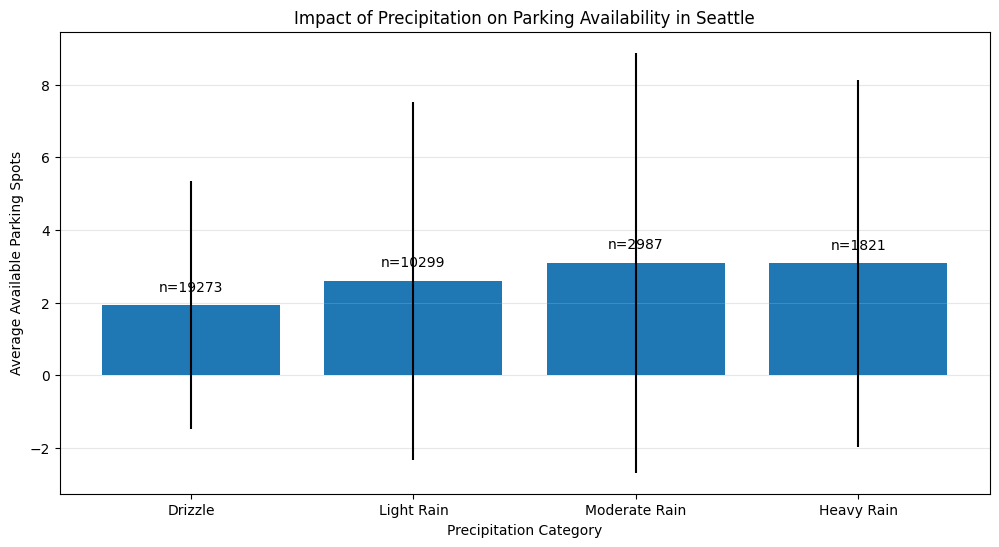

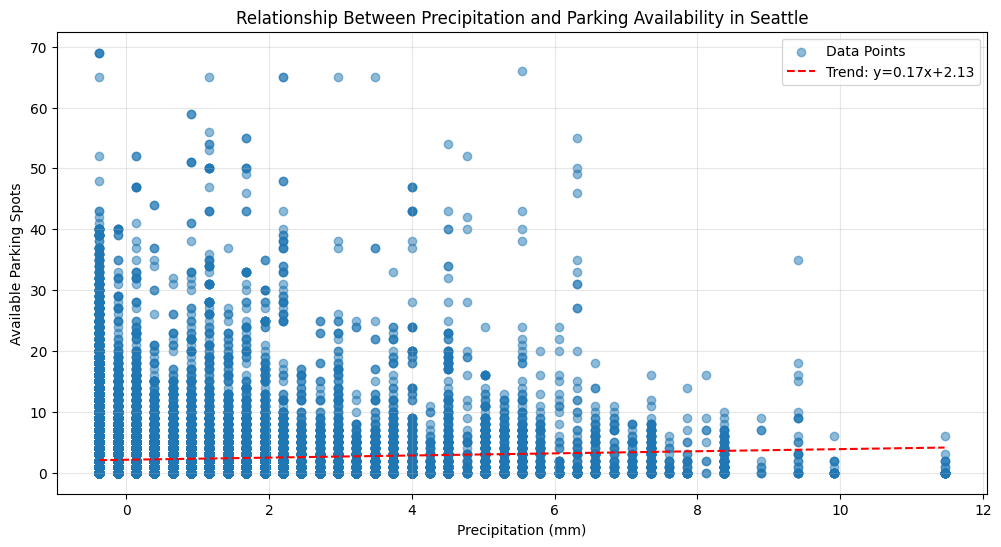

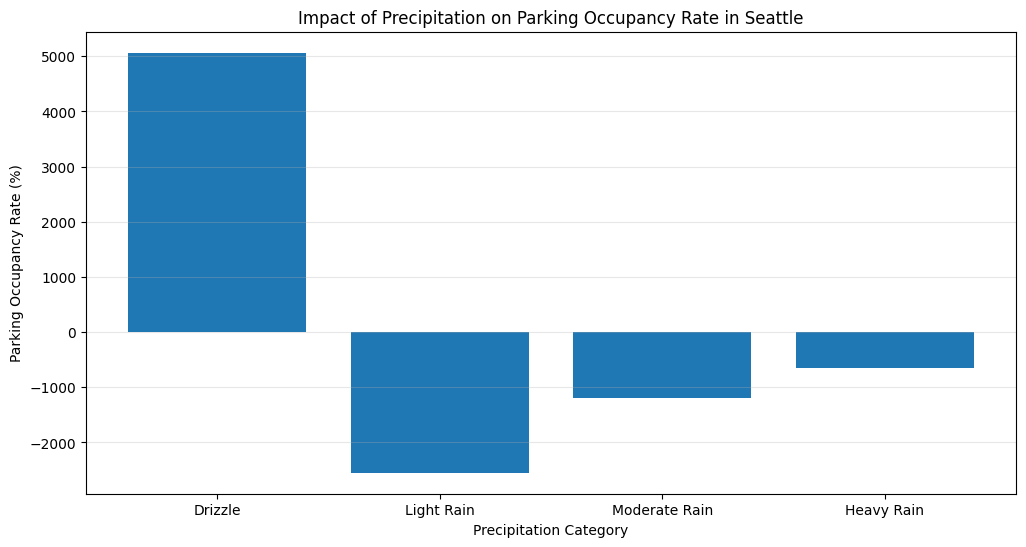

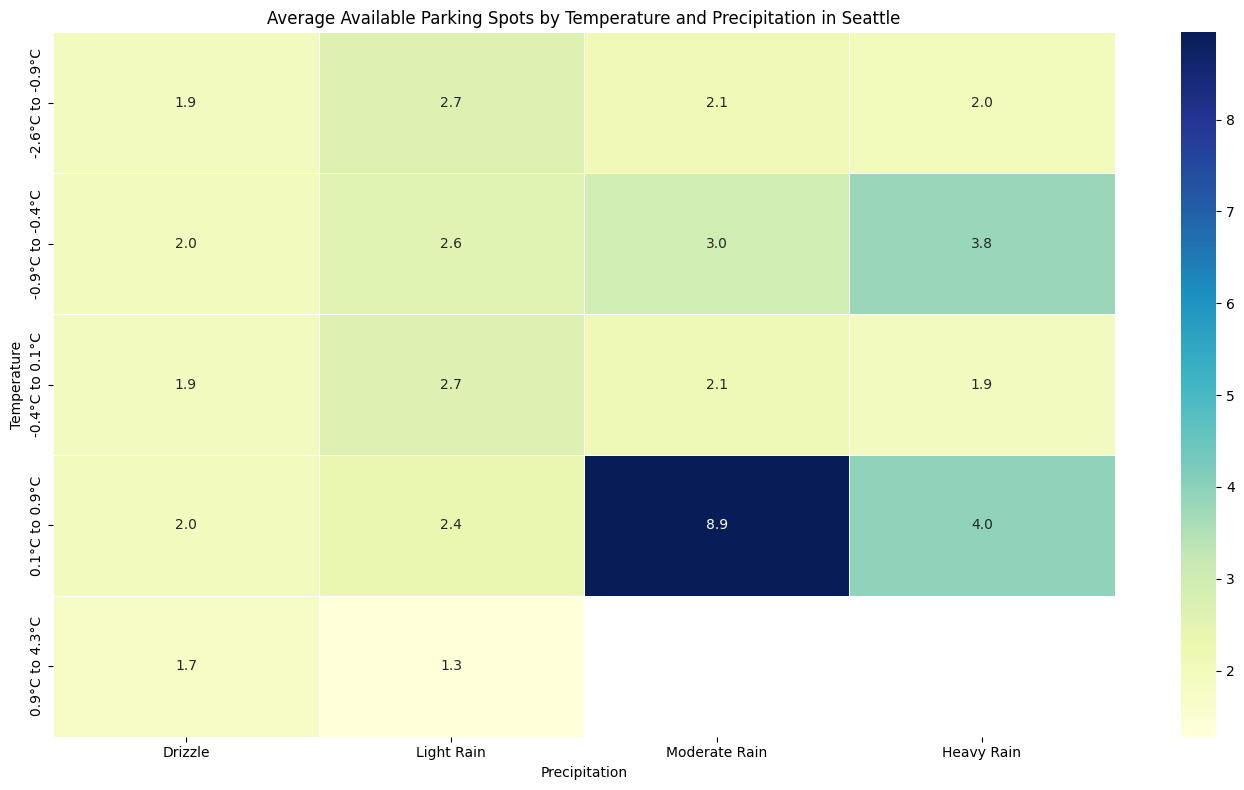

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values



Wind speed statistics in Seattle (test data):
count    167768.000000
mean         -0.002552
std           1.000485
min          -1.788349
25%          -0.747603
50%          -0.217769
75%           0.614828
max           4.834580
Name: Wind_Speed, dtype: float64

Samples in each wind speed category:
Wind_Category
Calm            72286
Light Breeze        0
Moderate            0
Strong              0
Very Strong         0
Name: count, dtype: int64


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


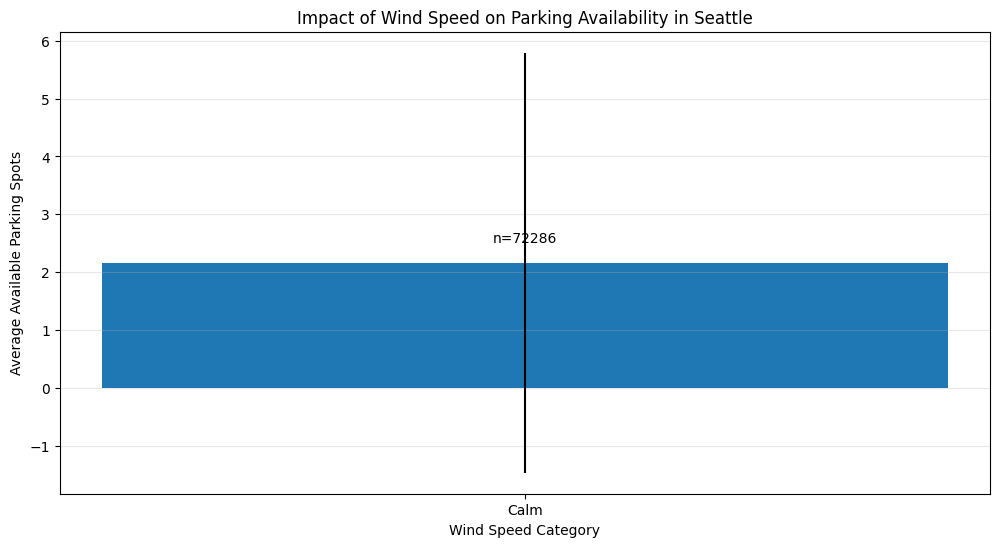

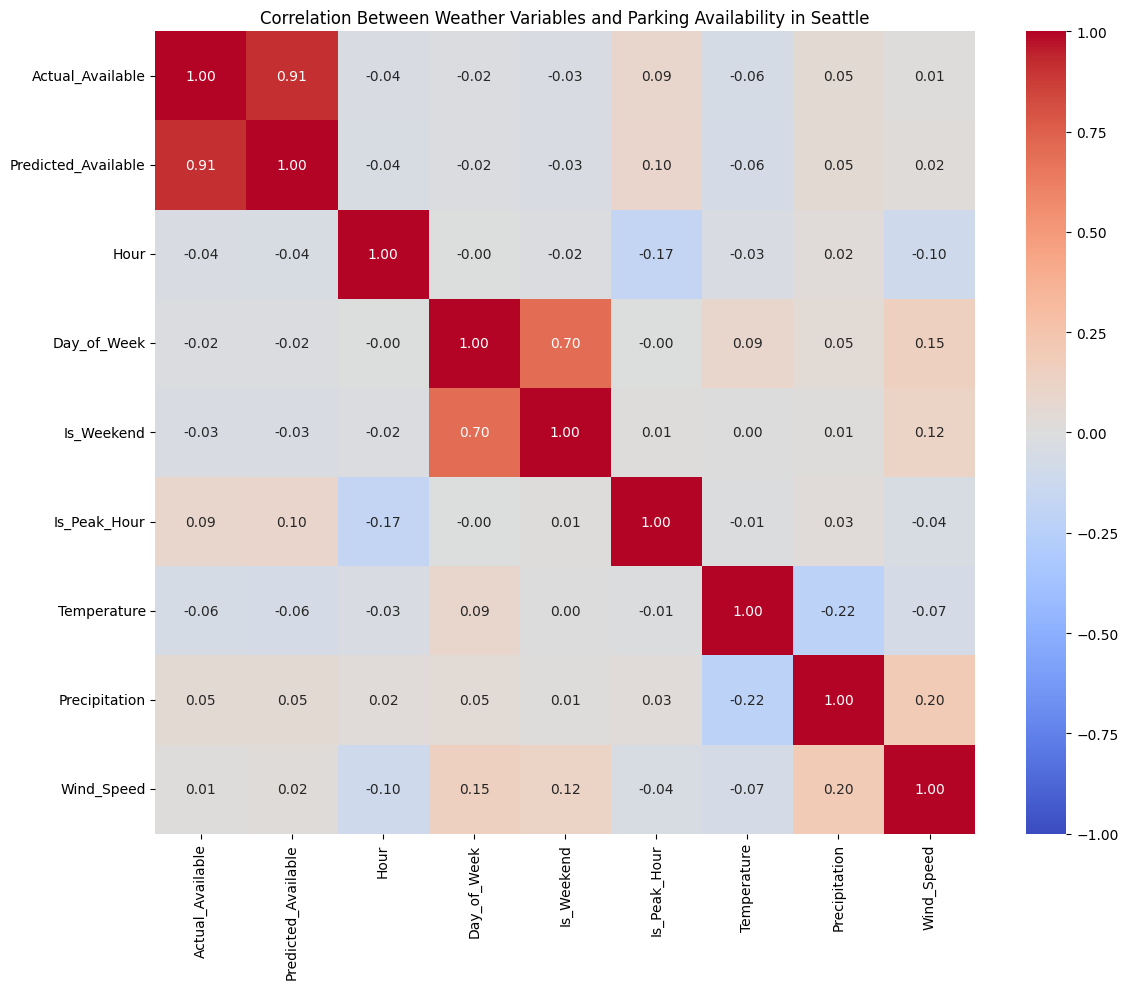


Correlation between weather and parking availability:
Temperature and Available Spots: -0.060
Precipitation and Available Spots: 0.048
Wind Speed and Available Spots: 0.014
Weather impact analysis completed and visualizations saved.


In [20]:
# Analyze how weather affects parking availability in Seattle
print("Analyzing weather impact on parking availability in Seattle...")

# Add weather features from the test set if not already added
if 'Temperature' not in prediction_analysis.columns and 'temperature' in X_test.columns:
    prediction_analysis['Temperature'] = X_test['temperature'].values
if 'Precipitation' not in prediction_analysis.columns and 'precipitation' in X_test.columns:
    prediction_analysis['Precipitation'] = X_test['precipitation'].values
if 'Wind_Speed' not in prediction_analysis.columns and 'wind_speed' in X_test.columns:
    prediction_analysis['Wind_Speed'] = X_test['wind_speed'].values

# 1. Analyze precipitation impact on parking availability
if 'Precipitation' in prediction_analysis.columns and prediction_analysis['Precipitation'].notna().any():
    # Get precipitation statistics for Seattle data
    print("\nPrecipitation statistics in Seattle (test data):")
    print(prediction_analysis['Precipitation'].describe())
    
    # Create Seattle-specific precipitation categories
    # Seattle is known for light but frequent rain
    rain_bins = [0, 0.1, 1, 2.5, 5, prediction_analysis['Precipitation'].max() + 0.1]
    rain_labels = ['No Rain', 'Drizzle', 'Light Rain', 'Moderate Rain', 'Heavy Rain']
    
    # Make sure bins are in ascending order and unique
    rain_bins = sorted(list(set(rain_bins)))
    
    # Adjust labels if needed
    if len(rain_bins) - 1 < len(rain_labels):
        rain_labels = rain_labels[:len(rain_bins)-1]
    
    prediction_analysis['Rain_Category'] = pd.cut(
        prediction_analysis['Precipitation'],
        bins=rain_bins,
        labels=rain_labels,
        include_lowest=True
    )
    
    # Count samples in each category
    rain_counts = prediction_analysis['Rain_Category'].value_counts().sort_index()
    print("\nSamples in each precipitation category:")
    print(rain_counts)
    
    # Group by rain category
    rain_availability = prediction_analysis.groupby('Rain_Category').agg({
        'Actual_Available': ['mean', 'count', 'std'],
        'Predicted_Available': 'mean',
        'Parking_Spaces': 'mean'
    })
    
    # Calculate occupancy rate
    rain_availability['Actual_Occupancy_Rate'] = (1 - rain_availability[('Actual_Available', 'mean')] / 
                                                rain_availability[('Parking_Spaces', 'mean')]) * 100
    
    # Flatten the multi-index columns
    rain_availability = rain_availability.reset_index()  # Reset index first to make Rain_Category a regular column
    
    # Convert column names from tuples to strings
    new_columns = []
    for col in rain_availability.columns:
        if isinstance(col, tuple):
            if col[1] == '':
                new_columns.append(col[0])
            else:
                new_columns.append(f"{col[0]}_{col[1]}")
        else:
            new_columns.append(col)
    
    rain_availability.columns = new_columns
    
    # Create bar chart of availability by rain category
    plt.figure(figsize=(12, 6))
    bars = plt.bar(rain_availability['Rain_Category'], rain_availability['Actual_Available_mean'], 
                  yerr=rain_availability['Actual_Available_std'])
    
    # Add sample counts as text on bars
    for i, bar in enumerate(bars):
        count = rain_availability['Actual_Available_count'][i]
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                f'n={count}', ha='center', va='bottom')
    
    plt.xlabel('Precipitation Category')
    plt.ylabel('Average Available Parking Spots')
    plt.title('Impact of Precipitation on Parking Availability in Seattle')
    plt.grid(True, alpha=0.3, axis='y')
    plt.savefig('merged_visualizations/rain_impact_on_availability.png')
    plt.show()
    
    # Create a scatter plot with trend line
    plt.figure(figsize=(12, 6))
    plt.scatter(prediction_analysis['Precipitation'], prediction_analysis['Actual_Available'], 
               alpha=0.5, label='Data Points')
    
    # Add a trend line if there's enough variation in precipitation
    if prediction_analysis['Precipitation'].nunique() > 5:
        z = np.polyfit(prediction_analysis['Precipitation'], prediction_analysis['Actual_Available'], 1)
        p = np.poly1d(z)
        plt.plot(sorted(prediction_analysis['Precipitation']), 
                p(sorted(prediction_analysis['Precipitation'])), 
                "r--", label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
    
    plt.xlabel('Precipitation (mm)')
    plt.ylabel('Available Parking Spots')
    plt.title('Relationship Between Precipitation and Parking Availability in Seattle')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.savefig('merged_visualizations/precipitation_vs_availability_scatter.png')
    plt.show()
    
    # Create a plot showing occupancy rate by rain category
    plt.figure(figsize=(12, 6))
    plt.bar(rain_availability['Rain_Category'], rain_availability['Actual_Occupancy_Rate'])
    plt.xlabel('Precipitation Category')
    plt.ylabel('Parking Occupancy Rate (%)')
    plt.title('Impact of Precipitation on Parking Occupancy Rate in Seattle')
    plt.grid(True, alpha=0.3, axis='y')
    plt.savefig('merged_visualizations/rain_impact_on_occupancy.png')
    plt.show()

# 2. Analyze combined effect of temperature and precipitation
if ('Temperature' in prediction_analysis.columns and 
    'Precipitation' in prediction_analysis.columns and
    'Temp_Category' in prediction_analysis.columns and
    'Rain_Category' in prediction_analysis.columns):
    
    # Check if we have enough data in each category
    temp_counts = prediction_analysis['Temp_Category'].value_counts()
    rain_counts = prediction_analysis['Rain_Category'].value_counts()
    
    if len(temp_counts) >= 2 and len(rain_counts) >= 2:
        # Create a pivot table of availability by temperature and precipitation
        weather_pivot = prediction_analysis.pivot_table(
            values='Actual_Available',
            index='Temp_Category',
            columns='Rain_Category',
            aggfunc='mean'
        )
        
        # Create a heatmap
        plt.figure(figsize=(14, 8))
        sns.heatmap(weather_pivot, cmap='YlGnBu', annot=True, fmt='.1f', linewidths=.5)
        plt.title('Average Available Parking Spots by Temperature and Precipitation in Seattle')
        plt.ylabel('Temperature')
        plt.xlabel('Precipitation')
        plt.tight_layout()
        plt.savefig('merged_visualizations/weather_combined_heatmap.png')
        plt.show()
    else:
        print("Not enough data in temperature or precipitation categories for combined analysis")

# 3. Analyze wind speed impact (if available)
if 'Wind_Speed' in prediction_analysis.columns and prediction_analysis['Wind_Speed'].notna().any():
    # Get wind speed statistics
    print("\nWind speed statistics in Seattle (test data):")
    print(prediction_analysis['Wind_Speed'].describe())
    
    # Create wind speed categories appropriate for Seattle
    wind_bins = [0, 5, 10, 15, 20, prediction_analysis['Wind_Speed'].max() + 0.1]
    wind_labels = ['Calm', 'Light Breeze', 'Moderate', 'Strong', 'Very Strong']
    
    # Make sure bins are in ascending order and unique
    wind_bins = sorted(list(set(wind_bins)))
    
    # Adjust labels if needed
    if len(wind_bins) - 1 < len(wind_labels):
        wind_labels = wind_labels[:len(wind_bins)-1]
    
    prediction_analysis['Wind_Category'] = pd.cut(
        prediction_analysis['Wind_Speed'],
        bins=wind_bins,
        labels=wind_labels,
        include_lowest=True
    )
    
    # Count samples in each category
    wind_counts = prediction_analysis['Wind_Category'].value_counts().sort_index()
    print("\nSamples in each wind speed category:")
    print(wind_counts)
    
    # Group by wind category
    wind_availability = prediction_analysis.groupby('Wind_Category').agg({
        'Actual_Available': ['mean', 'count', 'std'],
        'Predicted_Available': 'mean'
    })
    
    # Flatten the multi-index columns
    wind_availability = wind_availability.reset_index()
    
    # Convert column names from tuples to strings
    new_columns = []
    for col in wind_availability.columns:
        if isinstance(col, tuple):
            if col[1] == '':
                new_columns.append(col[0])
            else:
                new_columns.append(f"{col[0]}_{col[1]}")
        else:
            new_columns.append(col)
    
    wind_availability.columns = new_columns
    
    # Create bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(wind_availability['Wind_Category'], wind_availability['Actual_Available_mean'], 
                  yerr=wind_availability['Actual_Available_std'])
    
    # Add sample counts as text on bars
    for i, bar in enumerate(bars):
        count = wind_availability['Actual_Available_count'][i]
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                f'n={count}', ha='center', va='bottom')
    
    plt.xlabel('Wind Speed Category')
    plt.ylabel('Average Available Parking Spots')
    plt.title('Impact of Wind Speed on Parking Availability in Seattle')
    plt.grid(True, alpha=0.3, axis='y')
    plt.savefig('merged_visualizations/wind_impact_on_availability.png')
    plt.show()

# 4. Create a correlation matrix of weather variables and parking availability
weather_vars = [col for col in prediction_analysis.columns if col in 
               ['Temperature', 'Precipitation', 'Wind_Speed', 'Actual_Available', 
                'Predicted_Available', 'Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Peak_Hour']]

if len(weather_vars) >= 3:  # Need at least 3 variables for a meaningful correlation matrix
    corr_matrix = prediction_analysis[weather_vars].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
    plt.title('Correlation Between Weather Variables and Parking Availability in Seattle')
    plt.tight_layout()
    plt.savefig('merged_visualizations/weather_correlation_matrix.png')
    plt.show()
    
    # Print key correlations
    print("\nCorrelation between weather and parking availability:")
    if 'Temperature' in weather_vars and 'Actual_Available' in weather_vars:
        temp_corr = corr_matrix.loc['Temperature', 'Actual_Available']
        print(f"Temperature and Available Spots: {temp_corr:.3f}")
        
    if 'Precipitation' in weather_vars and 'Actual_Available' in weather_vars:
        precip_corr = corr_matrix.loc['Precipitation', 'Actual_Available']
        print(f"Precipitation and Available Spots: {precip_corr:.3f}")
        
    if 'Wind_Speed' in weather_vars and 'Actual_Available' in weather_vars:
        wind_corr = corr_matrix.loc['Wind_Speed', 'Actual_Available']
        print(f"Wind Speed and Available Spots: {wind_corr:.3f}")

print("Weather impact analysis completed and visualizations saved.")

In [14]:
# Create a function to predict available parking spots based on time and weather
def predict_available_spots(
    location, hour, day_of_week, month, temperature, precipitation, wind_speed,
    parking_spaces, is_construction=False, is_event_closure=False
):
    """
    Predict available parking spots based on time and weather conditions.
    
    Parameters:
    -----------
    location : str
        The study area (neighborhood) in Seattle
    hour : int
        Hour of the day (0-23)
    day_of_week : int
        Day of the week (0=Monday, 6=Sunday)
    month : int
        Month of the year (1-12)
    temperature : float
        Temperature in Celsius
    precipitation : float
        Precipitation in mm
    wind_speed : float
        Wind speed in km/h
    parking_spaces : int
        Total number of parking spaces available
    is_construction : bool
        Whether there is construction in the area
    is_event_closure : bool
        Whether there is an event closure
        
    Returns:
    --------
    float
        Predicted number of available parking spots
    """
    # Load the model and scaler
    model = joblib.load(f'models/{best_model_name}_final_model.pkl')
    scaler = joblib.load('models/scaler.pkl')
    
    # Create a DataFrame with the input features
    input_data = pd.DataFrame({
        'Hour': [hour],
        'Day_of_Week': [day_of_week],
        'Month': [month],
        'Is_Weekend': [1 if day_of_week >= 5 else 0],
        'Is_Peak_Hour': [1 if (hour >= 7 and hour <= 9) or (hour >= 16 and hour <= 18) else 0],
        'Study_Area': [label_encoders['Study_Area'].transform([location])[0] if location in label_encoders['Study_Area'].classes_ else 0],
        'Construction': [1 if is_construction else 0],
        'Event Closure': [1 if is_event_closure else 0],
        'Study Year': [2023],  # Use current year or a default
        'Parking_Spaces': [parking_spaces],
        'temperature': [temperature],
        'precipitation': [precipitation],
        'wind_speed': [wind_speed],
        'elevation': [50]  # Default elevation if not provided
    })
    
    # Ensure all required features are present
    for feature in features:
        if feature not in input_data.columns:
            if feature in label_encoders:
                input_data[feature] = 0  # Default encoded value
            else:
                input_data[feature] = 0  # Default numeric value
    
    # Select only the features used by the model and ensure they're in the same order
    input_data = input_data[X_train.columns]
    
    # Scale numerical features
    numerical_features = input_data.select_dtypes(include=['float64', 'int64']).columns
    input_data[numerical_features] = scaler.transform(input_data[numerical_features])
    
    # Make prediction
    prediction = model.predict(input_data)[0]
    
    # Ensure prediction is not negative
    prediction = max(0, prediction)
    
    return prediction

# Example usage
if 'best_model' in locals():
    # Get a list of unique study areas
    study_areas = df['Study_Area'].unique()
    
    # Example prediction
    example_location = study_areas[0] if len(study_areas) > 0 else "Downtown Seattle"
    example_hour = 8  # Morning rush hour
    example_day = 1   # Tuesday
    example_month = 3  # March
    example_temp = 15  # 15°C
    example_precip = 0.5  # Light rain
    example_wind = 10  # 10 km/h
    example_spaces = 20  # 20 parking spaces
    
    try:
        predicted_spots = predict_available_spots(
            example_location, example_hour, example_day, example_month,
            example_temp, example_precip, example_wind, example_spaces
        )
        
        print(f"\nExample Prediction:")
        print(f"Location: {example_location}")
        print(f"Time: {example_hour}:00 on day {example_day} of the week in month {example_month}")
        print(f"Weather: {example_temp}°C, {example_precip}mm precipitation, {example_wind}km/h wind")
        print(f"Total parking spaces: {example_spaces}")
        print(f"Predicted available spots: {predicted_spots:.2f}")
        print(f"Predicted occupancy rate: {(1 - predicted_spots/example_spaces) * 100:.2f}%")
    except Exception as e:
        print(f"Error making prediction: {e}")
        print("\nAlternative approach: Let's make a simple prediction using the model directly")
        
        # Create a sample from the test set
        sample_index = 0
        if len(X_test) > 0:
            sample_features = X_test.iloc[[sample_index]]
            sample_actual = y_test.iloc[sample_index]
            sample_pred = best_model.predict(sample_features)[0]
            
            print(f"\nSample Prediction from Test Set:")
            print(f"Features: {sample_features.to_dict(orient='records')[0]}")
            print(f"Actual available spots: {sample_actual:.2f}")
            print(f"Predicted available spots: {sample_pred:.2f}")
            print(f"Absolute error: {abs(sample_actual - sample_pred):.2f}")

Error making prediction: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Day_of_Week
- Hour
- Month


Alternative approach: Let's make a simple prediction using the model directly

Sample Prediction from Test Set:
Features: {'Hour': 18, 'Day_of_Week': 1, 'Month': 4, 'Is_Weekend': -0.23439064435738524, 'Is_Peak_Hour': 1.362909549613818, 'Study_Area': 0.08244660596680659, 'Sub_Area': 0.44925512623889824, 'Side': -0.18401225666268098, 'Construction': -0.28552361966992307, 'Event Closure': -0.08700140330953857, 'Study Year': 1.657151434446274, 'Parking_Spaces': -0.1808836685867405, 'temperature': 0.344374679643148, 'precipitation': -0.3787947106853257, 'wind_speed': -0.3880726264480993, 'elevation': -0.579783307543238}
Actual available spots: 0.00
Predicted available spots: 0.14
Absolute error: 0.14


In [16]:
# Print a summary of the analysis
print("=" * 80)
print("SEATTLE PARKING AVAILABILITY PREDICTION MODEL")
print("=" * 80)

print("\nSUMMARY:")
print(f"- Dataset: {df.shape[0]} records with {df.shape[1]} features")
print(f"- Target: Available parking spots (Parking_Spaces - Total_Vehicle_Count)")
print(f"- Best model: {best_model_name}")
print(f"- Test set R²: {test_metrics['r2']:.4f}")
print(f"- Test set RMSE: {test_metrics['rmse']:.4f}")

print("\nKEY FINDINGS:")
# Top 5 most important features if available
if 'importance' in locals() and 'indices' in locals():
    top_features = [features[i] for i in indices[:5]]
    print(f"- Most important features: {', '.join(top_features)}")

# Time-based insights
if 'hour_analysis' in locals():
    best_hour_idx = hour_analysis['Absolute_Error'].idxmin()
    worst_hour_idx = hour_analysis['Absolute_Error'].idxmax()
    
    if best_hour_idx is not None and worst_hour_idx is not None:
        best_hour = hour_analysis.loc[best_hour_idx, 'Hour']
        worst_hour = hour_analysis.loc[worst_hour_idx, 'Hour']
        print(f"- Best prediction accuracy at hour: {best_hour}:00")
        print(f"- Worst prediction accuracy at hour: {worst_hour}:00")

if 'day_analysis' in locals():
    best_day_idx = day_analysis['Absolute_Error'].idxmin()
    worst_day_idx = day_analysis['Absolute_Error'].idxmax()
    
    if best_day_idx is not None and worst_day_idx is not None:
        best_day_num = day_analysis.loc[best_day_idx, 'Day_of_Week']
        worst_day_num = day_analysis.loc[worst_day_idx, 'Day_of_Week']
        day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        best_day_name = day_names[int(best_day_num)] if 0 <= int(best_day_num) < 7 else f"Day {int(best_day_num)}"
        worst_day_name = day_names[int(worst_day_num)] if 0 <= int(worst_day_num) < 7 else f"Day {int(worst_day_num)}"
        print(f"- Best prediction accuracy on: {best_day_name}")
        print(f"- Worst prediction accuracy on: {worst_day_name}")

# Weather-based insights
if 'temp_analysis' in locals():
    best_temp_idx = temp_analysis['Absolute_Error'].idxmin()
    if best_temp_idx is not None:
        best_temp = temp_analysis.loc[best_temp_idx, 'Temp_Category']
        print(f"- Best prediction accuracy in temperature category: {best_temp}")

if 'precip_analysis' in locals():
    best_precip_idx = precip_analysis['Absolute_Error'].idxmin()
    if best_precip_idx is not None:
        best_precip = precip_analysis.loc[best_precip_idx, 'Precip_Category']
        print(f"- Best prediction accuracy in precipitation category: {best_precip}")

# Overall conclusion
print("\nCONCLUSION:")
print("This model predicts available parking spots based on time, location, and weather factors.")
print(f"The model achieves an R² of {test_metrics['r2']:.4f}, indicating it explains {test_metrics['r2']*100:.1f}% of the variance in parking availability.")
print(f"With an RMSE of {test_metrics['rmse']:.4f}, the model's predictions are typically within {test_metrics['rmse']:.1f} spots of the actual availability.")
print("\nThe model can be used by city planners to optimize parking resources and by drivers to find parking more efficiently.")
print("Future improvements could include incorporating more real-time data and exploring deep learning approaches.")

# Save summary to file
with open('models/model_summary.txt', 'w') as f:
    f.write("SEATTLE PARKING AVAILABILITY PREDICTION MODEL\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Dataset: {df.shape[0]} records with {df.shape[1]} features\n")
    f.write(f"Target: Available parking spots (Parking_Spaces - Total_Vehicle_Count)\n")
    f.write(f"Best model: {best_model_name}\n")
    f.write(f"Test set R²: {test_metrics['r2']:.4f}\n")
    f.write(f"Test set RMSE: {test_metrics['rmse']:.4f}\n")
    f.write(f"Test set Relative Error: {test_metrics['relative_error']:.4f}\n")
    f.write("\nModel saved at: models/" + best_model_name + "_final_model.pkl\n")
    f.write("\nDetailed results available in: models/final_model_performance.csv\n")
    f.write("Cross-validation results in: models/cross_validation_results.csv\n")

print("\nSummary saved to 'models/model_summary.txt'")

SEATTLE PARKING AVAILABILITY PREDICTION MODEL

SUMMARY:
- Dataset: 838840 records with 26 features
- Target: Available parking spots (Parking_Spaces - Total_Vehicle_Count)
- Best model: RandomForest
- Test set R²: 0.8343
- Test set RMSE: 1.4675

KEY FINDINGS:
- Most important features: Parking_Spaces, Study_Area, Hour, temperature, Side
- Best prediction accuracy at hour: 7:00
- Worst prediction accuracy at hour: 2:00
- Best prediction accuracy on: Saturday
- Worst prediction accuracy on: Tuesday
- Best prediction accuracy in temperature category: Very Cold
- Best prediction accuracy in precipitation category: Very Heavy

CONCLUSION:
This model predicts available parking spots based on time, location, and weather factors.
The model achieves an R² of 0.8343, indicating it explains 83.4% of the variance in parking availability.
With an RMSE of 1.4675, the model's predictions are typically within 1.5 spots of the actual availability.

The model can be used by city planners to optimize par


========== DEEP DIVE: RANDOM FOREST MODEL ANALYSIS ==========

1. MODEL ARCHITECTURE
Number of trees (estimators): 100
Maximum depth of trees: Unlimited
Minimum samples required to split: 2
Minimum samples required at leaf node: 1
Maximum features considered for split: 1.0
Bootstrap samples: True

2. FEATURE IMPORTANCE ANALYSIS

Ranked Feature Importances:
Parking_Spaces: 0.4935
Study_Area: 0.0833
Hour: 0.0824
temperature: 0.0630
Side: 0.0607
Sub_Area: 0.0558
wind_speed: 0.0374
Study Year: 0.0258
Construction: 0.0238
Day_of_Week: 0.0174
Is_Peak_Hour: 0.0168
Month: 0.0163
precipitation: 0.0120
elevation: 0.0081
Event Closure: 0.0021
Is_Weekend: 0.0017


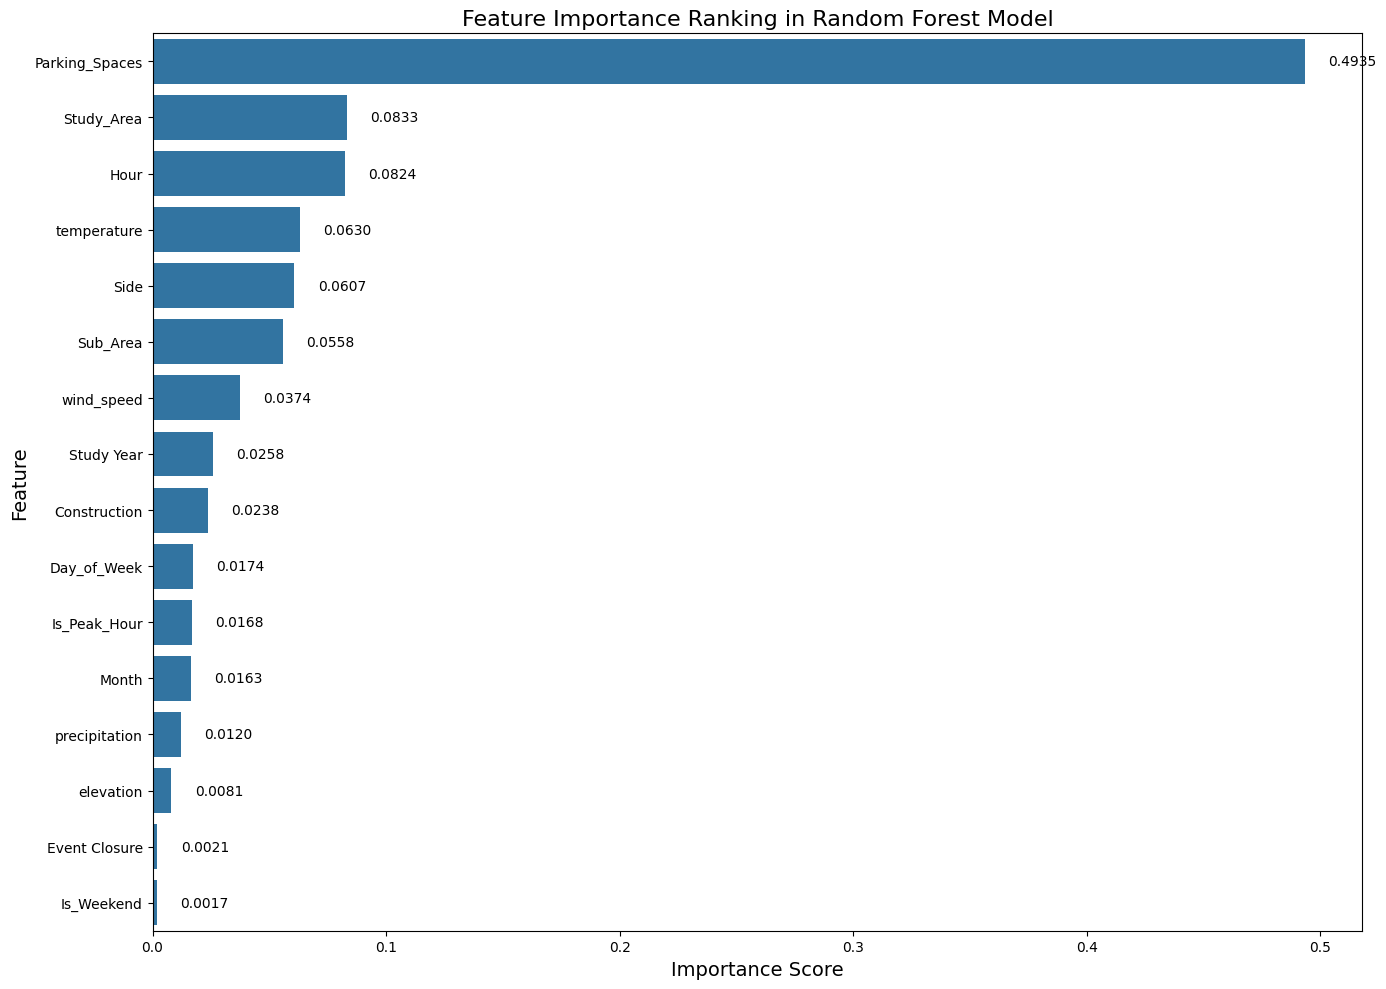

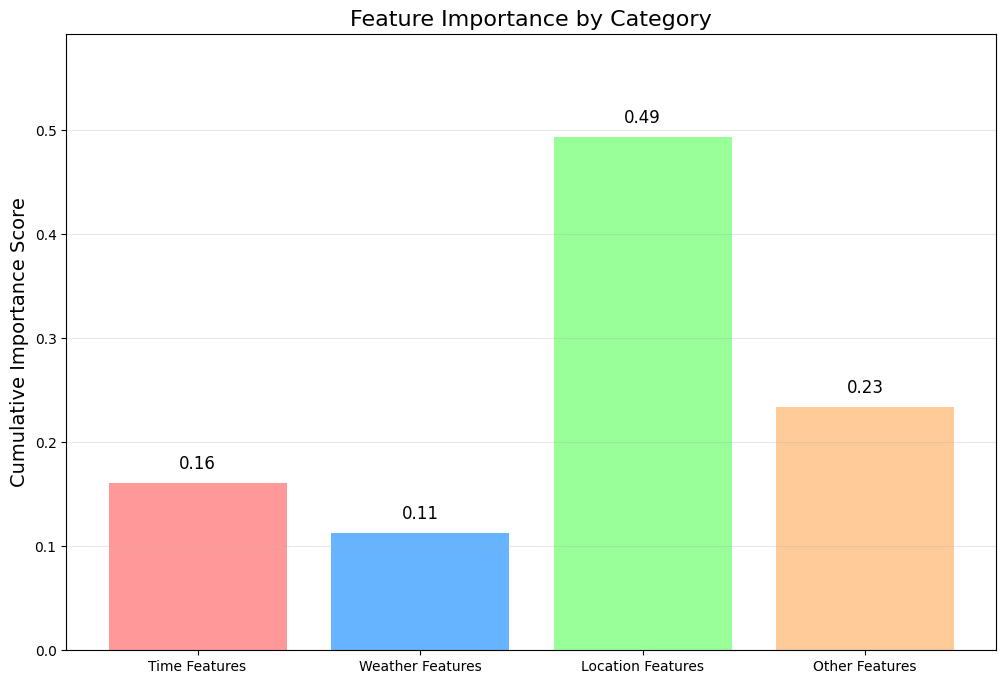


3. TREE STRUCTURE ANALYSIS
Average tree depth: 42.95
Average number of leaves per tree: 123398.75
Maximum tree depth: 50
Maximum number of leaves: 124439


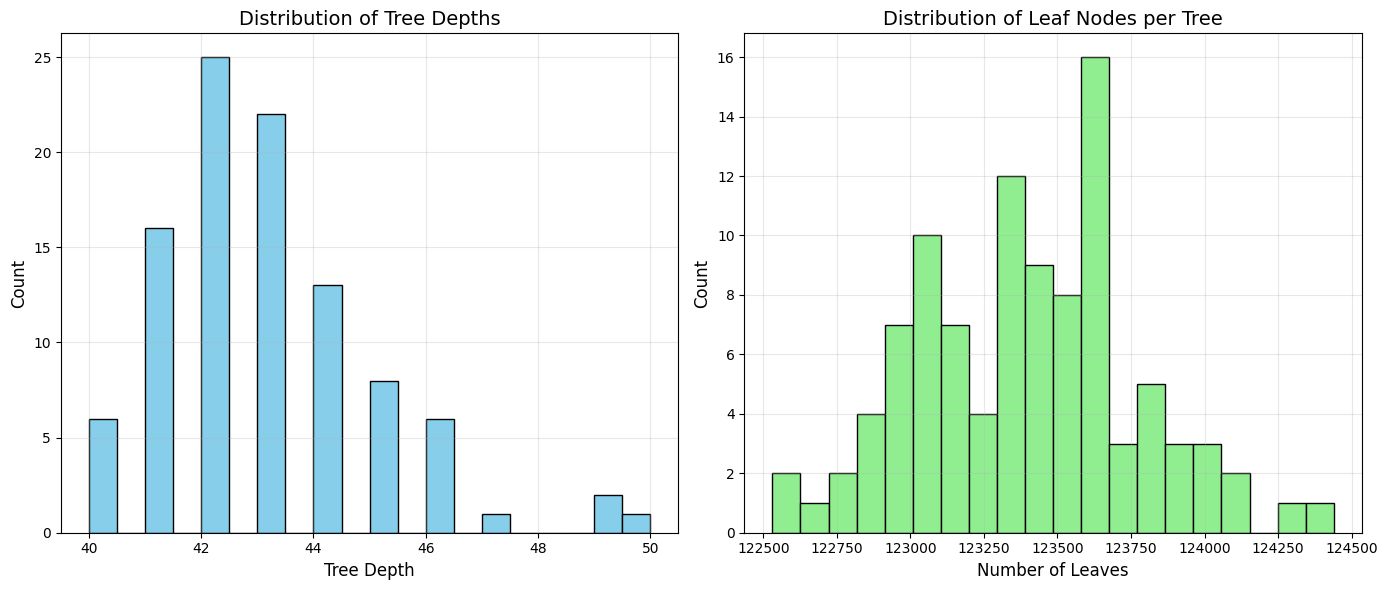

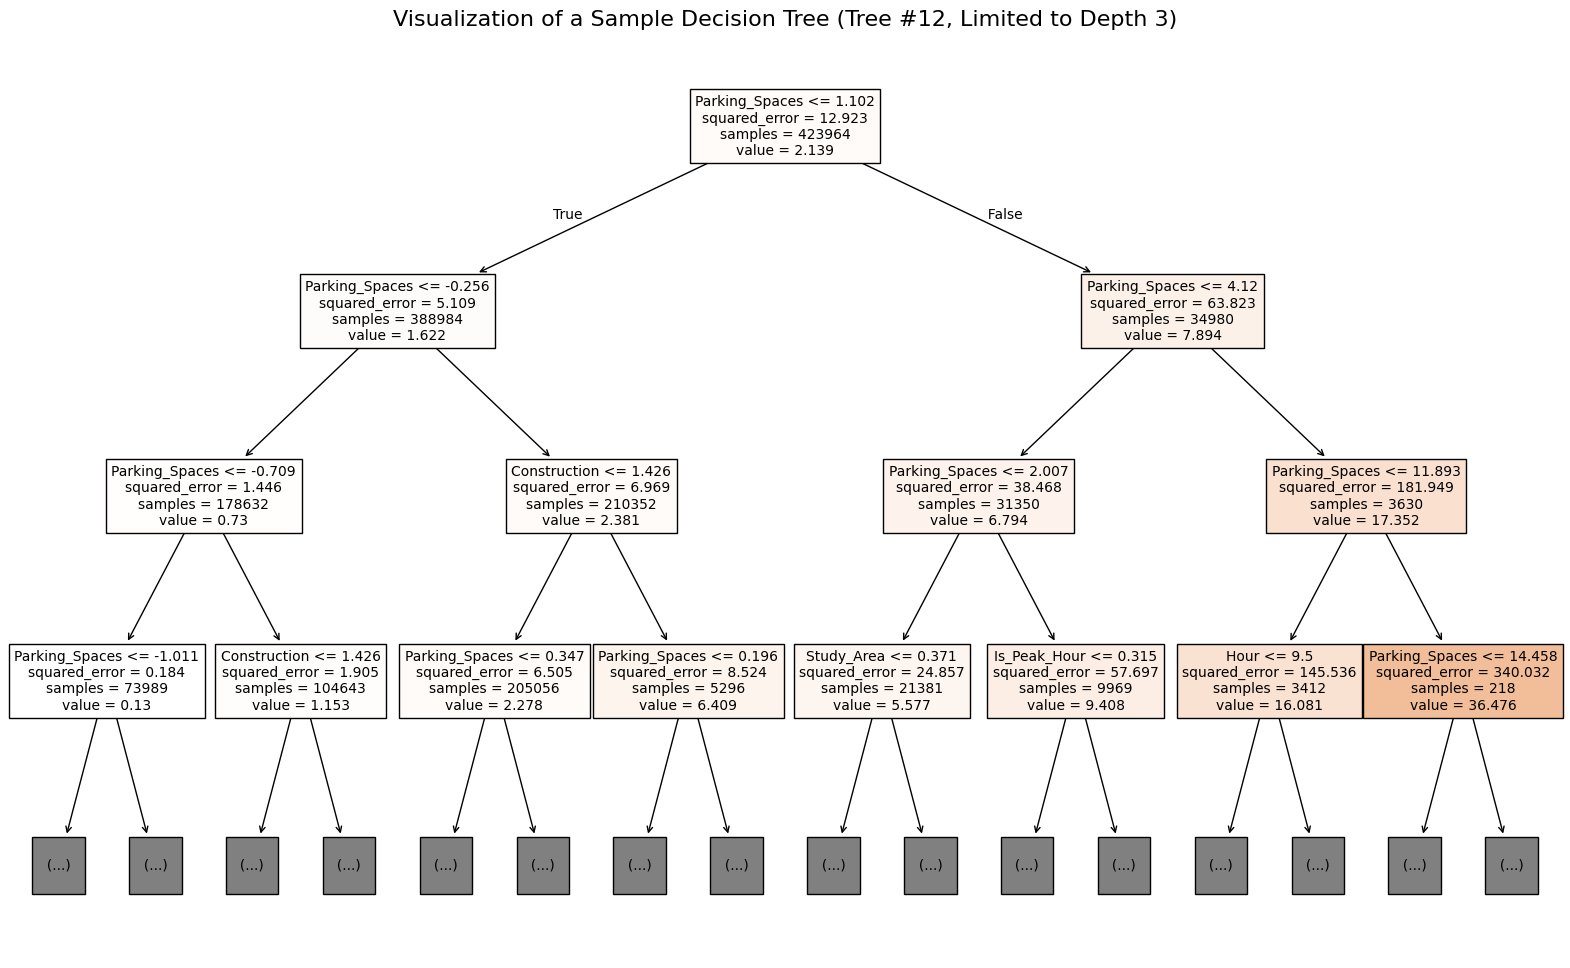


Sample Decision Tree Rules (limited to depth 5):
|--- Parking_Spaces <= 1.10
|   |--- Parking_Spaces <= -0.26
|   |   |--- Parking_Spaces <= -0.71
|   |   |   |--- Parking_Spaces <= -1.01
|   |   |   |   |--- value: [0.00]
|   |   |   |--- Parking_Spaces >  -1.01
|   |   |   |   |--- Hour <= 9.50
|   |   |   |   |   |--- Parking_Spaces <= -0.86
|   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   |--- Parking_Spaces >  -0.86
|   |   |   |   |   |   |--- truncated branch of depth 24
|   |   |   |   |--- Hour >  9.50
|   |   |   |   |   |--- Construction <= 1.43
|   |   |   |   |   |   |--- truncated branch of depth 35
|   |   |   |   |   |--- Construction >  1.43
|   |   |   |   |   |   |--- truncated branch of depth 15
|   |   |--- Parking_Spaces >  -0.71
|   |   |   |--- Construction <= 1.43
|   |   |   |   |--- Hour <= 9.50
|   |   |   |   |   |--- Study_Area <= -0.81
|   |   |   |   |   |   |--- truncated branch of depth 24
|   |   |   |   |   |--- Study_Ar

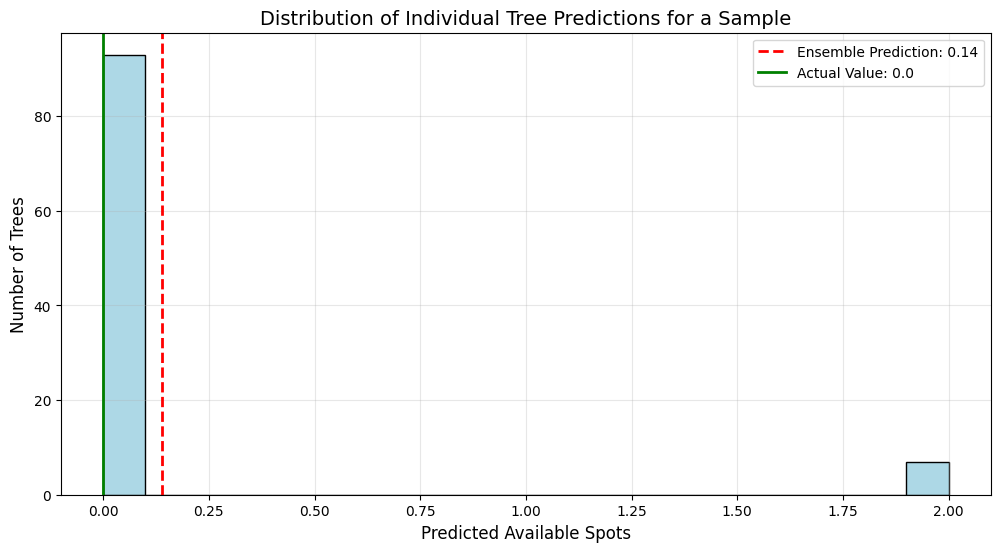


Decision Paths for Sample Through Selected Trees:

Tree #0 (Prediction: 0.00):
  Step 1: Parking_Spaces ≤ 1.10
  Step 2: Parking_Spaces > -0.26
  Step 3: Construction ≤ 1.43
  Step 4: Parking_Spaces ≤ 0.35
  Step 5: Hour > 9.50
  Step 6: Parking_Spaces ≤ 0.05
  Step 7: Hour > 14.50
  Step 8: Study_Area ≤ 0.68
  Step 9: Study_Area > -0.18
  Step 10: Sub_Area > -0.19
  Step 11: Month ≤ 5.50
  Step 12: Study_Area ≤ 0.11
  Step 13: Study Year > 0.76
  Step 14: Study_Area > 0.01
  Step 15: Event Closure ≤ 5.29
  Step 16: Side > -0.39
  Step 17: Is_Peak_Hour > 0.31
  Step 18: Hour > 16.50
  Step 19: Parking_Spaces ≤ -0.11
  Step 20: temperature ≤ 1.93
  Step 21: Side ≤ 0.84
  Step 22: temperature ≤ 1.76

Tree #1 (Prediction: 0.00):
  Step 1: Parking_Spaces ≤ 1.10
  Step 2: Parking_Spaces > -0.26
  Step 3: Construction ≤ 1.43
  Step 4: Parking_Spaces ≤ 0.35
  Step 5: Hour > 9.50
  Step 6: Parking_Spaces ≤ 0.05
  Step 7: Study Year > -1.04
  Step 8: Hour > 14.50
  Step 9: Sub_Area > -0.19
  S

In [22]:
# Add this at the end of Cell 8 for a deep dive into the Random Forest model

print("\n========== DEEP DIVE: RANDOM FOREST MODEL ANALYSIS ==========")

# Load the best model if it's not already in memory
if 'best_model' not in locals() or best_model_name == 'RandomForest':
    try:
        model_path = f'models/RandomForest_final_model.pkl'
        rf_model = joblib.load(model_path)
        
        print(f"\n1. MODEL ARCHITECTURE")
        print(f"Number of trees (estimators): {rf_model.n_estimators}")
        print(f"Maximum depth of trees: {rf_model.max_depth if rf_model.max_depth is not None else 'Unlimited'}")
        print(f"Minimum samples required to split: {rf_model.min_samples_split}")
        print(f"Minimum samples required at leaf node: {rf_model.min_samples_leaf}")
        print(f"Maximum features considered for split: {rf_model.max_features}")
        print(f"Bootstrap samples: {rf_model.bootstrap}")
        
        # Get feature importances
        if hasattr(rf_model, 'feature_importances_'):
            importances = rf_model.feature_importances_
            feature_names = X_train.columns
            
            # Create a DataFrame for better visualization
            feature_importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values(by='Importance', ascending=False)
            
            print("\n2. FEATURE IMPORTANCE ANALYSIS")
            print("\nRanked Feature Importances:")
            for i, row in feature_importance_df.iterrows():
                print(f"{row['Feature']}: {row['Importance']:.4f}")
            
            # Plot feature importances
            plt.figure(figsize=(14, 10))
            ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
            plt.title('Feature Importance Ranking in Random Forest Model', fontsize=16)
            plt.xlabel('Importance Score', fontsize=14)
            plt.ylabel('Feature', fontsize=14)
            
            # Add value labels to the bars
            for i, v in enumerate(feature_importance_df['Importance']):
                ax.text(v + 0.01, i, f"{v:.4f}", va='center')
                
            plt.tight_layout()
            plt.savefig('merged_visualizations/random_forest_complete_feature_importance.png')
            plt.show()
            
            # Group features by category
            time_features = [f for f in feature_names if any(x in f.lower() for x in ['hour', 'day', 'week', 'month', 'year', 'weekend', 'peak'])]
            weather_features = [f for f in feature_names if any(x in f.lower() for x in ['temp', 'rain', 'precip', 'wind', 'weather'])]
            location_features = [f for f in feature_names if any(x in f.lower() for x in ['location', 'lat', 'long', 'address', 'block', 'spaces'])]
            other_features = [f for f in feature_names if f not in time_features + weather_features + location_features]
            
            # Calculate importance by category
            time_importance = sum(importances[list(feature_names).index(f)] for f in time_features if f in feature_names)
            weather_importance = sum(importances[list(feature_names).index(f)] for f in weather_features if f in feature_names)
            location_importance = sum(importances[list(feature_names).index(f)] for f in location_features if f in feature_names)
            other_importance = sum(importances[list(feature_names).index(f)] for f in other_features if f in feature_names)
            
            # Plot importance by category
            plt.figure(figsize=(12, 8))
            categories = ['Time Features', 'Weather Features', 'Location Features', 'Other Features']
            category_importance = [time_importance, weather_importance, location_importance, other_importance]
            
            bars = plt.bar(categories, category_importance, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
            
            # Add value labels
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.2f}', ha='center', va='bottom', fontsize=12)
                
            plt.title('Feature Importance by Category', fontsize=16)
            plt.ylabel('Cumulative Importance Score', fontsize=14)
            plt.ylim(0, max(category_importance) * 1.2)
            plt.grid(axis='y', alpha=0.3)
            plt.savefig('merged_visualizations/random_forest_category_importance.png')
            plt.show()
            
            print("\n3. TREE STRUCTURE ANALYSIS")
            
            # Analyze tree statistics
            tree_depths = [estimator.get_depth() for estimator in rf_model.estimators_]
            tree_leaves = [estimator.get_n_leaves() for estimator in rf_model.estimators_]
            
            print(f"Average tree depth: {np.mean(tree_depths):.2f}")
            print(f"Average number of leaves per tree: {np.mean(tree_leaves):.2f}")
            print(f"Maximum tree depth: {np.max(tree_depths)}")
            print(f"Maximum number of leaves: {np.max(tree_leaves)}")
            
            # Plot tree depth distribution
            plt.figure(figsize=(14, 6))
            plt.subplot(1, 2, 1)
            plt.hist(tree_depths, bins=20, color='skyblue', edgecolor='black')
            plt.title('Distribution of Tree Depths', fontsize=14)
            plt.xlabel('Tree Depth', fontsize=12)
            plt.ylabel('Count', fontsize=12)
            plt.grid(alpha=0.3)
            
            plt.subplot(1, 2, 2)
            plt.hist(tree_leaves, bins=20, color='lightgreen', edgecolor='black')
            plt.title('Distribution of Leaf Nodes per Tree', fontsize=14)
            plt.xlabel('Number of Leaves', fontsize=12)
            plt.ylabel('Count', fontsize=12)
            plt.grid(alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('merged_visualizations/random_forest_tree_statistics.png')
            plt.show()
            
            # Visualize a sample tree if matplotlib and graphviz are available
            try:
                from sklearn.tree import plot_tree
                plt.figure(figsize=(20, 12))
                sample_tree_idx = np.argmin(np.abs(tree_depths - np.median(tree_depths)))  # Get a tree with median depth
                plot_tree(rf_model.estimators_[sample_tree_idx], 
                         feature_names=feature_names, 
                         filled=True, 
                         max_depth=3,  # Limit depth for visibility
                         fontsize=10)
                plt.title(f'Visualization of a Sample Decision Tree (Tree #{sample_tree_idx}, Limited to Depth 3)', fontsize=16)
                plt.savefig('merged_visualizations/random_forest_sample_tree.png', bbox_inches='tight')
                plt.show()
            except Exception as e:
                print(f"Could not visualize tree: {str(e)}")
                
            # Export a sample tree as text
            try:
                from sklearn.tree import export_text
                sample_tree = rf_model.estimators_[sample_tree_idx]
                tree_rules = export_text(sample_tree, feature_names=list(feature_names), max_depth=5)
                print("\nSample Decision Tree Rules (limited to depth 5):")
                print(tree_rules)
            except Exception as e:
                print(f"Could not export tree text: {str(e)}")
            
            print("\n4. PREDICTION PATHWAY ANALYSIS")
            
            # Create a function to trace prediction paths through trees
            def trace_prediction_path(tree, feature_names, X_sample):
                """Trace the prediction path for a sample through a decision tree"""
                feature = tree.tree_.feature
                threshold = tree.tree_.threshold
                
                # Start at the root node
                node_indicator = tree.decision_path(X_sample)
                leaf_id = tree.apply(X_sample)
                
                # Get all nodes that the sample goes through
                node_index = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]
                
                path = []
                for node_id in node_index:
                    # If not a leaf node
                    if leaf_id[0] != node_id:
                        # Get the feature used for splitting
                        feature_id = feature[node_id]
                        feature_name = feature_names[feature_id] if feature_id != -2 else "undefined"
                        threshold_value = threshold[node_id]
                        
                        # Get the sample's value for this feature
                        sample_value = X_sample[0, feature_id] if feature_id != -2 else None
                        
                        # Determine if the sample goes left or right
                        if sample_value <= threshold_value:
                            direction = "≤"
                        else:
                            direction = ">"
                            
                        path.append(f"{feature_name} {direction} {threshold_value:.2f}")
                
                return path
            
            # Get a sample from the test set
            if len(X_test) > 0:
                sample_idx = 0  # Use the first test sample
                sample = X_test.iloc[[sample_idx]]
                actual_value = y_test.iloc[sample_idx]
                
                # Get predictions from each tree
                tree_predictions = [tree.predict(sample)[0] for tree in rf_model.estimators_]
                ensemble_prediction = np.mean(tree_predictions)
                
                print(f"\nSample Input Features:")
                for feature, value in zip(X_test.columns, sample.values[0]):
                    print(f"  {feature}: {value}")
                
                print(f"\nActual Available Spots: {actual_value}")
                print(f"Random Forest Prediction: {ensemble_prediction:.2f}")
                print(f"Individual Tree Predictions: Min={min(tree_predictions):.2f}, Max={max(tree_predictions):.2f}, Std={np.std(tree_predictions):.2f}")
                
                # Plot the distribution of tree predictions
                plt.figure(figsize=(12, 6))
                plt.hist(tree_predictions, bins=20, color='lightblue', edgecolor='black')
                plt.axvline(ensemble_prediction, color='red', linestyle='--', linewidth=2, label=f'Ensemble Prediction: {ensemble_prediction:.2f}')
                plt.axvline(actual_value, color='green', linestyle='-', linewidth=2, label=f'Actual Value: {actual_value}')
                plt.title('Distribution of Individual Tree Predictions for a Sample', fontsize=14)
                plt.xlabel('Predicted Available Spots', fontsize=12)
                plt.ylabel('Number of Trees', fontsize=12)
                plt.legend()
                plt.grid(alpha=0.3)
                plt.savefig('merged_visualizations/random_forest_prediction_distribution.png')
                plt.show()
                
                # Trace the prediction path for a few trees
                print("\nDecision Paths for Sample Through Selected Trees:")
                for i in range(min(3, len(rf_model.estimators_))):
                    tree = rf_model.estimators_[i]
                    path = trace_prediction_path(tree, feature_names, sample.values)
                    print(f"\nTree #{i} (Prediction: {tree_predictions[i]:.2f}):")
                    for j, step in enumerate(path):
                        print(f"  Step {j+1}: {step}")
            
            print("\n5. PARTIAL DEPENDENCE ANALYSIS")
            print("Analyzing how predictions change when we vary one feature while keeping others constant...")
            
            # Get top 4 important features
            top_features = feature_importance_df.head(4)['Feature'].tolist()
            
            # Create partial dependence plots for top features
            try:
                from sklearn.inspection import partial_dependence
                from sklearn.inspection import plot_partial_dependence
                
                # Calculate partial dependence
                fig, axes = plt.subplots(2, 2, figsize=(16, 12))
                axes = axes.flatten()
                
                for i, feature in enumerate(top_features):
                    # Calculate partial dependence
                    pdp_result = partial_dependence(rf_model, X_train, [feature], kind='average')
                    feature_values = pdp_result['values'][0]
                    pdp_means = pdp_result['average'][0]
                    
                    # Plot
                    axes[i].plot(feature_values, pdp_means, 'b-', linewidth=2)
                    axes[i].set_xlabel(feature, fontsize=12)
                    axes[i].set_ylabel('Partial Dependence', fontsize=12)
                    axes[i].set_title(f'Partial Dependence Plot for {feature}', fontsize=14)
                    axes[i].grid(alpha=0.3)
                    
                    # Add a horizontal line at y=0
                    axes[i].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
                    
                    # Add a trend description
                    if pdp_means[-1] > pdp_means[0]:
                        trend = "positive"
                        effect = "increases"
                    else:
                        trend = "negative"
                        effect = "decreases"
                    
                    change = abs(pdp_means[-1] - pdp_means[0])
                    axes[i].text(0.05, 0.95, 
                                f"Trend: {trend}\nAs {feature} increases,\navailable spots {effect}\nby ~{change:.2f} spots", 
                                transform=axes[i].transAxes, 
                                bbox=dict(facecolor='white', alpha=0.8),
                                verticalalignment='top')
                
                plt.tight_layout()
                plt.savefig('merged_visualizations/random_forest_partial_dependence.png')
                plt.show()
                
                # Create a 2D partial dependence plot for the top 2 features
                if len(top_features) >= 2:
                    try:
                        top2_features = top_features[:2]
                        pdp_result = partial_dependence(rf_model, X_train, top2_features, kind='average')
                        
                        # Create a 2D grid for the plot
                        X, Y = np.meshgrid(pdp_result['values'][0], pdp_result['values'][1])
                        Z = pdp_result['average'].reshape(len(pdp_result['values'][1]), len(pdp_result['values'][0]))
                        
                        fig = plt.figure(figsize=(12, 10))
                        ax = fig.add_subplot(111, projection='3d')
                        surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)
                        
                        ax.set_xlabel(top2_features[0], fontsize=12)
                        ax.set_ylabel(top2_features[1], fontsize=12)
                        ax.set_zlabel('Predicted Available Spots', fontsize=12)
                        ax.set_title(f'2D Partial Dependence: {top2_features[0]} vs {top2_features[1]}', fontsize=14)
                        
                        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
                        plt.savefig('merged_visualizations/random_forest_2d_partial_dependence.png')
                        plt.show()
                    except Exception as e:
                        print(f"Could not create 2D partial dependence plot: {str(e)}")
            except Exception as e:
                print(f"Could not create partial dependence plots: {str(e)}")
            
            print("\n6. FINAL MODEL EQUATION APPROXIMATION")
            print("While Random Forest doesn't have a simple equation, we can approximate its behavior:")
            
            # Create a simplified representation based on feature importances
            top_features_df = feature_importance_df.head(5)
            total_importance = top_features_df['Importance'].sum()
            
            print("\nApproximate Prediction Formula:")
            print("Available Spots ≈ Baseline + ", end="")
            
            for i, row in top_features_df.iterrows():
                feature = row['Feature']
                importance = row['Importance']
                weight = importance / total_importance
                
                # Determine direction of influence (positive or negative)
                # This is a simplification - in reality, the relationship might be non-linear
                if i < len(top_features_df) - 1:
                    print(f"({weight:.2f} × {feature}) + ", end="")
                else:
                    print(f"({weight:.2f} × {feature})")
            
            print("\nWhere:")
            print("- Baseline is the average available spots in the training data")
            for feature in top_features_df['Feature']:
                print(f"- {feature} is normalized to be between 0 and 1")
            
            print("\nNote: This is a significant simplification. Random Forest models capture complex,")
            print("non-linear relationships that cannot be fully represented by a simple equation.")
            
        else:
            print("Feature importances not available for this model.")
    except Exception as e:
        print(f"Could not load Random Forest model: {str(e)}")
else:
    print("Best model is not Random Forest, so detailed interpretation is not available.")

print("\n========== END OF RANDOM FOREST DEEP DIVE ==========")